# This is the first attempt of inpaint

I'm not having much time to spend in this project, but this is what I've done so far.

The code is really poorly commented, there are parts of the code that are really messy, but as soon as I have the time to get back to it, I'll make things look better.

I'm not satisfied with the results either, I'll try an statistical approach.

In [639]:
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
import numpy as np
from math import inf
from matplotlib import colors

def histogram(A, no_levels=255, normalized=True):
    no_levels = int(no_levels)

    # creates an empty histogram with size proportional to the number of graylevels 
    hist = np.zeros(no_levels, dtype=np.uint32)

    if normalized:
        A_n = A
    else:
        A_n = normalize(A, rmin=0, rmax=no_levels).astype(np.uint32)

    # computes for all levels in the range
    for i in range(no_levels):
        # the np.where() function returns the indices for all coordinates 
        # in some array matching the condition. In this case, all pixels
        # that have value 'i'
        pixels_value_i = np.where(A_n == i)

        #print(pixels_value_i)  # uncomment to print array of coordinates

        # by counting how many coordinates the np.where function returned, 
        # we can assign it at the respective histogram bin
        # this is done by getting the size of the vector of coordinates
        hist[i] = pixels_value_i[0].shape[0]

    return (hist)

def lawsHist(laws_em, colorLevels=None, imprime=False):
    hist = []
    if(colorLevels):
        for i in range(len(laws_em)):
            hist.append(histogram(laws_em[i], colorLevels[i]))
            print("len hist", len(hist))
            print("shape hist[i]", hist[i].shape)
            if imprime:
                print("len hist", len(hist))
                print("shape hist[i]", hist[i].shape)
                #print(hist[i])
                plt.bar(range(int(colorLevels[i])), hist[i], align='center')
                plt.yscale('log')
                plt.show()
        hist = np.array(hist)
        #print("retornando hist com shape", hist.shape)
        #print(len(hist[0]))
        return hist

    colorLevels = []
    for i in range(len(laws_em)):
        colorLevels.append(laws_em[i].max() - laws_em[i].min() + 1)
        hist.append(histogram(laws_em[i], colorLevels[i]))
        if imprime:
            print("len hist", len(hist))
            print("shape hist[i]", hist[i].shape)
            #print(hist[i])
            plt.bar(range(int(colorLevels[i])), hist[i], align='center')
            plt.yscale('log')
            plt.show()

    return (np.array(hist), np.sum(np.array(colorLevels, dtype=np.uint32)));

def lawsWindowedHist(laws_em, colorLevels, imprime=False):
    hist = np.array(1)
    for i in range(len(laws_em)):
        hist_i = np.zeros(colorLevels[i])
        #for pixel in laws_em[i]:
            #print(pixel)
            #print("\n")
            #print(laws_em[i])
        hist_i[laws_em[i].astype(np.uint32)] += 1
        #print("len hist", len(hist))
        #print("shape hist[i]", hist[i].shape)
        #print("hist_i", hist_i)
        #print("hist_i[0]", hist_i[0])
        if imprime:
            print("len hist", len(hist))
            print("shape hist[i]", hist[i].shape)
            #print(hist[i])
            plt.bar(range(int(colorLevels[i])), hist[i], align='center')
            plt.yscale('log')
            plt.show()
        hist = np.append(hist, hist_i)
    #print("len hist[0]", len(hist[0]))
    #hist = np.array(hist)
    #print("retornando hist com shape", hist.shape)
    #print(len(hist[0]))
    return hist

# binarize an image with LBP technique
def rebinarize(fimg, pad):
    im = fimg[pad:-pad, pad:-pad]
    #rimg = np.array(im).astype(np.uint8)
    f8 = np.greater(fimg[:fimg.shape[0] - 2, :fimg.shape[1] - 2], im).astype(np.uint8)
    f7 = np.left_shift(np.greater(fimg[:fimg.shape[0] - 2, 1:fimg.shape[1] - 1], im), 1)
    f6 = np.left_shift(np.greater(fimg[:fimg.shape[0] - 2, 2:], im), 2)
    f5 = np.left_shift(np.greater(fimg[1:fimg.shape[0] - 1, 2:], im), 3)
    f4 = np.left_shift(np.greater(fimg[2:, 2:], im), 4)
    f3 = np.left_shift(np.greater(fimg[2:, 1:fimg.shape[1] - 1], im), 5)
    f2 = np.left_shift(np.greater(fimg[2:, :fimg.shape[1] - 2], im), 6)
    f1 = np.left_shift(np.greater(fimg[1:fimg.shape[0] - 1, :fimg.shape[1] - 2], im), 7)
    # uncomment lines bellow to see the result of each bit from the final image
    #plt.figure(dpi=200)
    #plt.subplot(421)
    #plt.imshow(f1, cmap = 'gray'); plt.axis('off'); plt.title("bit 7")
    #plt.subplot(422)
    #plt.imshow(f2, cmap = 'gray'); plt.axis('off'); plt.title("bit 6")
    #plt.subplot(423)
    #plt.imshow(f3, cmap = 'gray'); plt.axis('off'); plt.title("bit 5")
    #plt.subplot(424)
    #plt.imshow(f4, cmap = 'gray'); plt.axis('off'); plt.title("bit 4")
    #plt.subplot(425)
    #plt.imshow(f5, cmap = 'gray'); plt.axis('off'); plt.title("bit 3")
    #plt.subplot(426)
    #plt.imshow(f6, cmap = 'gray'); plt.axis('off'); plt.title("bit 2")
    #plt.subplot(427)
    #plt.imshow(f7, cmap = 'gray'); plt.axis('off'); plt.title("bit 1")
    #plt.subplot(428)
    #plt.imshow(f8, cmap = 'gray'); plt.axis('off'); plt.title("bit 0")
    #plt.show()
    rimg = np.sum([f1, f2, f3, f4, f5, f6, f7, f8], axis = 0).astype(np.uint8)

    return rimg

# binarize an image with LBP technique
def binarize(im):
    fimg = np.zeros((im.shape[0] + 2, im.shape[1] + 2)).astype(np.uint8)
    fimg[1 : 1 + im.shape[0], 1 : 1 + im.shape[1]] = im
    #rimg = np.array(im).astype(np.uint8)
    f8 = np.greater(fimg[:fimg.shape[0] - 2, :fimg.shape[1] - 2], im).astype(np.uint8)
    f7 = np.left_shift(np.greater(fimg[:fimg.shape[0] - 2, 1:fimg.shape[1] - 1], im), 1)
    f6 = np.left_shift(np.greater(fimg[:fimg.shape[0] - 2, 2:], im), 2)
    f5 = np.left_shift(np.greater(fimg[1:fimg.shape[0] - 1, 2:], im), 3)
    f4 = np.left_shift(np.greater(fimg[2:, 2:], im), 4)
    f3 = np.left_shift(np.greater(fimg[2:, 1:fimg.shape[1] - 1], im), 5)
    f2 = np.left_shift(np.greater(fimg[2:, :fimg.shape[1] - 2], im), 6)
    f1 = np.left_shift(np.greater(fimg[1:fimg.shape[0] - 1, :fimg.shape[1] - 2], im), 7)
    # uncomment lines bellow to see the result of each bit from the final image
    #plt.figure(dpi=200)
    #plt.subplot(421)
    #plt.imshow(f1, cmap = 'gray'); plt.axis('off'); plt.title("bit 7")
    #plt.subplot(422)
    #plt.imshow(f2, cmap = 'gray'); plt.axis('off'); plt.title("bit 6")
    #plt.subplot(423)
    #plt.imshow(f3, cmap = 'gray'); plt.axis('off'); plt.title("bit 5")
    #plt.subplot(424)
    #plt.imshow(f4, cmap = 'gray'); plt.axis('off'); plt.title("bit 4")
    #plt.subplot(425)
    #plt.imshow(f5, cmap = 'gray'); plt.axis('off'); plt.title("bit 3")
    #plt.subplot(426)
    #plt.imshow(f6, cmap = 'gray'); plt.axis('off'); plt.title("bit 2")
    #plt.subplot(427)
    #plt.imshow(f7, cmap = 'gray'); plt.axis('off'); plt.title("bit 1")
    #plt.subplot(428)
    #plt.imshow(f8, cmap = 'gray'); plt.axis('off'); plt.title("bit 0")
    #plt.show()
    rimg = np.sum([f1, f2, f3, f4, f5, f6, f7, f8], axis = 0).astype(np.uint8)

    return rimg

# the function used to remove ilumination effects in the given image, used as preprocessing of
# the image in the Laws texture energy
def removeLuminosityEffect(im):
    pimg = zeroPaddify(im, 7)
    rangej = range(7, im.shape[1] + 7)
    fimg = im.copy().astype(float)
    for i in range(7, im.shape[0] + 7):
        for j in rangej:
            li_i = i - 7
            li_j = j - 7
            mean = np.mean(pimg[li_i:i+7, li_j:j+7])
            fimg[li_i][li_j] -= mean
    return fimg

def removeLuminosityEffect2(im):
    return colors.rgb_to_luv(im)[:,:,2]

# function to pad an image with zeros
# returns the given image padded with zeros to match the dimensions given in dimf
# exemples:
# 3x3 padded to be a 8x8         3x3 padded to be a 9x9
#   |0 0 0 0 0 0 0 0|             |0 0 0 0 0 0 0 0 0|
#   |0 0 0 0 0 0 0 0|             |0 0 0 0 0 0 0 0 0|
#   |0 0 0 0 0 0 0 0|             |0 0 0 0 0 0 0 0 0|
#   |0 0 0 x x x 0 0|             |0 0 0 x x x 0 0 0|
#   |0 0 0 x x x 0 0|             |0 0 0 x x x 0 0 0|
#   |0 0 0 x x x 0 0|             |0 0 0 x x x 0 0 0|
#   |0 0 0 0 0 0 0 0|             |0 0 0 0 0 0 0 0 0|
#   |0 0 0 0 0 0 0 0|             |0 0 0 0 0 0 0 0 0|
#                                 |0 0 0 0 0 0 0 0 0|
def zeroPaddifyTo(im, dimf):
    # computes the pad in x
    padx = dimf[0] // 2 - im.shape[0] // 2
    # computes the pad in y
    pady = dimf[1] // 2 - im.shape[1] // 2
    # alocates the new padded image with zeros
    newim = np.zeros(dimf, dtype=im.dtype)

    # copies the original image on the center of the new one
    newim[padx : padx + im.shape[0], pady : pady + im.shape[1]] = im

    return newim

# function that paddifies a matrix by 'pad' number of zeros in both axis
def zeroPaddify(im, pad):
    newim = np.zeros((im.shape[0] + 2 * pad, im.shape[1] + 2 * pad), dtype=im.dtype)
    newim[pad : pad + im.shape[0], pad : pad + im.shape[1]] = im
    return newim

def zeroPaddify4(im, padL, padR, padT, padB):
    newim = np.zeros((im.shape[0] + padL + padR, im.shape[1] + padT + padB), dtype=im.dtype)
    newim[padL : padL + im.shape[0], padT : padT + im.shape[1]] = im
    return newim

# function that constructs a symmetric matrix to get a
# padded matrix symetric in its limits
# for example a matrix of weights 5x5 processing a matrix
# also 5x5 would need a padded matrix like the following
# to process all pixels correctly
#                                         A       |       B        |      C
#                                           7  2  | 6  7  8  9  10 | 4  9
#                                           6  1  | 1  2  3  4  5  | 5  10
#                                        ------------------------------------
#              1  2  3  4  5                2  1  | 1  2  3  4  5  | 5  4
#              6  7  8  9  10               7  6  | 6  7  8  9  10 | 10 9
# original --> 11 12 13 14 15  padded --> H 12 11 | 11 12 13 14 15 | 15 14 D
#  image       16 17 18 19 20    one        17 16 | 16 17 18 19 20 | 20 19
#              21 22 23 24 25               22 21 | 21 22 23 24 25 | 25 24
#                                        ------------------------------------
#                                           16 21 | 21 22 23 24 25 | 25 20
#                                           17 22 | 16 17 18 19 20 | 24 19
#                                         G       |       F        |       E
def symPaddify(im, pad):
    newim = np.zeros((im.shape[0] + 2 * pad, im.shape[1] + 2 * pad))

    # creates the center of the padded image
    newim[pad : pad + im.shape[0], pad : pad + im.shape[1]] = im

    # creates the A region of the padded image
    newim[0:pad, 0:pad] = im[pad-1::-1, pad-1::-1]

    # creates the B region of the padded image
    newim[0:pad, pad:newim.shape[1]-pad] = im[pad-1::-1, :]

    # creates the C region of the padded image
    newim[0:pad, -pad:] = im[pad-1::-1, -1:-pad-1:-1]

    # creates the D region of the padded image
    newim[pad:newim.shape[0]-pad, -pad:] = im[:, -1:-pad-1:-1]

    # creates the E region of the padded image
    newim[-pad:, -pad:] = im[-1:-pad-1:-1, -1:-pad-1:-1]

    # creates the F region of the padded image
    newim[-pad:, pad:newim.shape[1]-pad] = im[-1:-pad-1:-1, :]

    # creates the G region of the padded image
    newim[-pad:, 0:pad] = im[-1:-pad-1:-1, pad-1::-1]

    # creates the H region of the padded image
    newim[pad:newim.shape[0]-pad, 0:pad] = im[:, pad-1::-1]

    return newim

def filtering2D(im, weights):
    n = len(weights[0])
    wcenter = n // 2 # the center of the weights matrix, assumes that it is a square matrix

    sym = symPaddify(im, wcenter)

    # filters the image
    fimg = np.zeros(im.shape)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            # gets a submatrix of the image centered at [i, j]
            submat = sym[i : n + i : 1, j : n + j : 1]
            # gets the sum of the dot product of the rows of the submatrix and the rows of the weights matrix
            for k in range(n):
                fimg[i][j] += np.abs(np.dot(submat[k], weights[k]))

    return fimg

def filtering2DFFT(im, weights):
    fftim = ifftshift(fft2(im))
    fftweights = ifftshift(fft2(zeroPaddifyTo(weights, fftim.shape)))
    fftfiltered = np.multiply(fftim, fftweights)
    return np.abs(ifftshift(ifft2(fftfiltered))).astype(float)

def rgb2gray(im):
    if (len(im.shape) == 3) and (im.shape[2] > 1):
        return np.dot(im[:,:,:3].astype(float), [0.2989, 0.5870, 0.1140])
    return im

# the function to compute the 9 Laws texture energy maps
def getLawsEnergyMaps(im):
    # here are defined the 16 matrices used on the cross correlation
    # to get the 16 maps
    L5E5 = np.array([[ -1.0,  -2.0,   0.0,   2.0,   1.0],
            [ -4.0,  -8.0,   0.0,   8.0,   4.0],
            [ -6.0, -12.0,   0.0,  12.0,   6.0],
            [ -4.0,  -8.0,   0.0,   8.0,   4.0],
            [ -1.0,  -2.0,   0.0,   2.0,   1.0]])
    E5L5 = np.array([[ -1.0,  -4.0,  -6.0,  -4.0,  -1.0],
            [ -2.0,  -8.0, -12.0,  -8.0,  -2.0],
            [  0.0,   0.0,   0.0,   0.0,   0.0],
            [  2.0,   8.0,  12.0,   8.0,   2.0],
            [  1.0,   4.0,   6.0,   4.0,   1.0]])
    L5R5 = np.array([[  1.0,  -4.0,   6.0,  -4.0,   1.0],
            [  4.0, -16.0,  24.0, -16.0,   4.0],
            [  6.0, -24.0,  36.0, -24.0,   6.0],
            [  4.0, -16.0,  24.0, -16.0,   4.0],
            [  1.0,  -4.0,   6.0,  -4.0,   1.0]])
    R5L5 = np.array([[  1.0,   4.0,   6.0,   4.0,   1.0],
            [ -4.0, -16.0, -24.0, -16.0,  -4.0],
            [  6.0,  24.0,  36.0,  24.0,   6.0],
            [ -4.0, -16.0, -24.0, -16.0,  -4.0],
            [  1.0,   4.0,   6.0,   4.0,   1.0]])
    E5S5 = np.array([[ 1.0, -0.0, -2.0, -0.0,  1.0],
            [ 2.0, -0.0, -4.0, -0.0,  2.0],
            [-0.0,  0.0,  0.0,  0.0, -0.0],
            [-2.0,  0.0,  4.0,  0.0, -2.0],
            [-1.0,  0.0,  2.0,  0.0, -1.0]])
    S5E5 = np.array([[ 1.0,  2.0, -0.0, -2.0, -1.0],
            [-0.0, -0.0,  0.0,  0.0,  0.0],
            [-2.0, -4.0,  0.0,  4.0,  2.0],
            [-0.0, -0.0,  0.0,  0.0,  0.0],
            [ 1.0,  2.0, -0.0, -2.0, -1.0]])
    S5S5 = np.array([[ 1.0, -0.0, -2.0, -0.0,  1.0],
            [-0.0,  0.0,  0.0,  0.0, -0.0],
            [-2.0,  0.0,  4.0,  0.0, -2.0],
            [-0.0,  0.0,  0.0,  0.0, -0.0],
            [ 1.0, -0.0, -2.0, -0.0,  1.0]])
    R5R5 = np.array([[  1.0,  -4.0,   6.0,  -4.0,   1.0],
            [ -4.0,  16.0, -24.0,  16.0,  -4.0],
            [  6.0, -24.0,  36.0, -24.0,   6.0],
            [ -4.0,  16.0, -24.0,  16.0,  -4.0],
            [  1.0,  -4.0,   6.0,  -4.0,   1.0]])
    L5S5 = np.array([[-1.0,  0.0,  2.0,  0.0, -1.0],
            [-4.0,  0.0,  8.0,  0.0, -4.0],
            [-6.0,  0.0, 12.0,  0.0, -6.0],
            [-4.0,  0.0,  8.0,  0.0, -4.0],
            [-1.0,  0.0,  2.0,  0.0, -1.0]])
    S5L5 = np.array([[-1.0, -4.0, -6.0, -4.0, -1.0],
            [ 0.0,  0.0,  0.0,  0.0,  0.0],
            [ 2.0,  8.0, 12.0,  8.0,  2.0],
            [ 0.0,  0.0,  0.0,  0.0,  0.0],
            [-1.0, -4.0, -6.0, -4.0, -1.0]])
    E5E5 = np.array([[ 1.0,  2.0, -0.0, -2.0, -1.0],
            [ 2.0,  4.0, -0.0, -4.0, -2.0],
            [-0.0, -0.0,  0.0,  0.0,  0.0],
            [-2.0, -4.0,  0.0,  4.0,  2.0],
            [-1.0, -2.0,  0.0,  2.0,  1.0]])
    E5R5 = np.array([[ -1.0,   4.0,  -6.0,   4.0,  -1.0],
            [ -2.0,   8.0, -12.0,   8.0,  -2.0],
            [  0.0,  -0.0,   0.0,  -0.0,   0.0],
            [  2.0,  -8.0,  12.0,  -8.0,   2.0],
            [  1.0,  -4.0,   6.0,  -4.0,   1.0]])
    R5E5 = np.array([[ -1.0,  -2.0,   0.0,   2.0,   1.0],
            [  4.0,   8.0,  -0.0,  -8.0,  -4.0],
            [ -6.0, -12.0,   0.0,  12.0,   6.0],
            [  4.0,   8.0,  -0.0,  -8.0,  -4.0],
            [ -1.0,  -2.0,   0.0,   2.0,   1.0]])
    S5R5 = np.array([[-1.0,  4.0, -6.0,  4.0, -1.0],
            [ 0.0, -0.0,  0.0, -0.0,  0.0],
            [ 2.0, -8.0, 12.0, -8.0,  2.0],
            [ 0.0, -0.0,  0.0, -0.0,  0.0],
            [-1.0,  4.0, -6.0,  4.0, -1.0]])
    R5S5 = np.array([[-1.0,  0.0,  2.0,  0.0, -1.0],
            [ 4.0, -0.0, -8.0, -0.0,  4.0],
            [-6.0,  0.0, 12.0,  0.0, -6.0],
            [ 4.0, -0.0, -8.0, -0.0,  4.0],
            [-1.0,  0.0,  2.0,  0.0, -1.0]])
    # converts the image into gray scale
    im_gray = rgb2gray(im)
    # removes the luminosity effects of the image
    im_sem_luz = removeLuminosityEffect(im_gray)
    # computes the 16 energy maps
    im_L5E5 = filtering2DFFT(im_sem_luz, L5E5).astype(float)
    im_E5L5 = filtering2DFFT(im_sem_luz, E5L5).astype(float)
    im_L5R5 = filtering2DFFT(im_sem_luz, L5R5).astype(float)
    im_R5L5 = filtering2DFFT(im_sem_luz, R5L5).astype(float)
    im_E5S5 = filtering2DFFT(im_sem_luz, E5S5).astype(float)
    im_S5E5 = filtering2DFFT(im_sem_luz, S5E5).astype(float)
    im_S5S5 = filtering2DFFT(im_sem_luz, S5S5).astype(float)
    im_R5R5 = filtering2DFFT(im_sem_luz, R5R5).astype(float)
    im_L5S5 = filtering2DFFT(im_sem_luz, L5S5).astype(float)
    im_S5L5 = filtering2DFFT(im_sem_luz, S5L5).astype(float)
    im_E5E5 = filtering2DFFT(im_sem_luz, E5E5).astype(float)
    im_E5R5 = filtering2DFFT(im_sem_luz, E5R5).astype(float)
    im_R5E5 = filtering2DFFT(im_sem_luz, R5E5).astype(float)
    im_S5R5 = filtering2DFFT(im_sem_luz, S5R5).astype(float)
    im_R5S5 = filtering2DFFT(im_sem_luz, R5S5).astype(float)
    # summarizes then in 9 maps by averaging the symetric ones
    im_fs = []
    im_fs.append(((im_L5E5 + im_E5L5) / 2.0))
    im_fs.append(((im_L5R5 + im_R5L5) / 2.0))
    im_fs.append(((im_E5S5 + im_S5E5) / 2.0))
    im_fs.append(im_S5S5)
    im_fs.append(im_R5R5)
    im_fs.append(((im_L5S5 + im_S5L5) / 2.0))
    im_fs.append(im_E5E5)
    im_fs.append(((im_E5R5 + im_R5E5) / 2.0))
    im_fs.append(((im_S5R5 + im_R5S5) / 2.0))

    return (np.array(im_fs), im_sem_luz)

# class that will select the next pixel to inpaint based on
# the position of the pixel.
# the sequence of inpainting will be from left to right, from top to bottom
# 3x3 image example, as the arrows show:
#     ---------->
#    | |0 0 0 0 0|
#    | |0 0 1 0 0|
#    | |0 1 1 1 0|
#    | |1 1 1 1 1|
#    V |0 1 1 1 0|
class seqSelector:
    def __init__(self, im, mask_limiar=10):
        self._pixelsList = np.where(im > mask_limiar)
        self._listIndex = 0
        self._pixelsListLen = len(self._pixelsList[0])
        self._onePixPercent = 1.0 / self._pixelsListLen
        self._percent = 0.0
        #print("pixelsList", self._pixelsList)
        print("pixelsListLen", self._pixelsListLen)

    def next(self):
        if(self._listIndex < self._pixelsListLen):
            nexPix = (self._pixelsList[0][self._listIndex], self._pixelsList[1][self._listIndex])
            self._listIndex += 1
            self._percent += self._onePixPercent
            return (nexPix, self._percent)
        else:
            return (None, 100.0)

# the function that computes the distance of im1 and im2
# uses the euclidean distance
def compare(im1, im2):
    return np.sqrt(np.divide(np.sum(np.square(np.subtract(im2.astype(float), im1.astype(float)))), im1.shape[0]))

def compareLawsWindowedHistRegions(region1, region2, colorLevels):
    return compare(lawsWindowedHist(region1, colorLevels), lawsWindowedHist(region2, colorLevels))

class matcher:
    def __init__(self, im, mask, window_match_size=3, recompute=False, window_tex_size=3, texType="laws", lawsUsedMaps=None, normalizeMaps=True, mask_limiar=10):
        self._windowMatchRange = window_match_size // 2
        self._windowTexRange = window_tex_size // 2
        self._windowTexSize = window_tex_size
        self._recompute = recompute

        inpaintPixels = np.where(mask > mask_limiar)
        validPixels = np.where(mask <= mask_limiar)
        mask[inpaintPixels] = 255

        # removes the pixels that have windows over pixels to inpaintPixels
        for i in range(inpaintPixels[0].shape[0]):
            validIndexes = np.where((np.abs(validPixels[0] - inpaintPixels[0][i]) > self._windowMatchRange) | ((np.abs(validPixels[1] - inpaintPixels[1][i])) > self._windowMatchRange))
            validPixels = (validPixels[0][validIndexes], validPixels[1][validIndexes])

        self._matchingPixels = validPixels

        hehe=np.zeros(mask.shape)
        hehe[validPixels] = 2
        hehe[inpaintPixels] = 1
        plt.imshow(hehe, cmap='gray')
        plt.show()

        if (texType == "lawsHist") or (texType == "laws"):
            lawsEM, self._im = getLawsEnergyMaps(im)
            if lawsUsedMaps:
                lawsEM = lawsEM[lawsUsedMaps, :]
            lawsEM_min = np.min(lawsEM)
            lawsEM_max = np.max(lawsEM)

            if len(im.shape) > 2:
                if im.shape[2] > 3:
                    irange = range(3)
                else:
                    irange = range(im.shape[2])
                for i in irange:
                    lawsEM = np.append(lawsEM, [im[:,:,i]], axis=0)
                self._im_depth = i + 1
            else:
                lawsEM = np.append(lawsEM, [im], axis=0)
                self._im_depth = 1
            self._tex = [[]] * len(lawsEM[0])

            if texType == "lawsHist":
                self._colorLevels = []
                for i in range(len(lawsEM)):
                    self._colorLevels.append(int(lawsEM[i].max() - lawsEM[i].min()))
                    lawsEM[i] = normalize(lawsEM[i], rmin=0, rmax=self._colorLevels[i] - 1)
                self._compare = lambda reg1, reg2 : compareLawsWindowedHistRegions(reg1, reg2, self._colorLevels)
            else:
                self._compare = compare
                if normalizeMaps:
                    for i in range(len(lawsEM)):
                        lawsEM[i] = normalize(lawsEM[i], rmin=0, rmax=np.abs(lawsEM_min)+np.abs(lawsEM_max))

            self._recomputeTexFunc = lambda im : getLawsEnergyMaps(im)[0]
            self._tex = np.array(lawsEM)
        ###### end of the Laws constructor particularities ######
        elif (texType == "lbp") or (texType == "lbpHist"):
            self._im = rgb2gray(im)
            lbpIm = binarize(self._im)
            self._tex = np.array([lbpIm, self._im])
            self._im_depth = 1
            if texType == "lbpHist":
                self._colorLevels = []
                for i in range(len(self._tex)):
                    self._colorLevels.append(int(self._tex[i].max() - self._tex[i].min()))
                    self._tex[i] = normalize(self._tex[i], rmin=0, rmax=self._colorLevels[i] - 1)
                self._compare = lambda reg1, reg2 : compareLawsWindowedHistRegions(reg1, reg2, self._colorLevels)
            else:
                self._compare = compare
            self._recomputeTexFunc = lambda im : rebinarize(im, self._windowTexRange)
        ###### end of the LBP constructor particularities ######

        self._maxX = im.shape[1]#len(self._tex[0][0])
        self._maxY = im.shape[0]#len(self._tex[0])

        #for i in irange:
        #    for j in jrange:
        #        winMinX, winMaxX, winMinY, winMaxY = self._getBoundingLimits((i,j))[4:]
                #print("limites ((", winMinX, "\b,", winMaxX, "\b), (", winMinY, "\b,", winMaxY, "\b))")
                #print("shape da janela resultante", lawsEM[:, i-winMinX:i+winMaxX, j-winMinY:j+winMaxY].shape)
        #        self._tex[i].append(lawsWindowHist(lawsEM[:, i-winMinX:i+winMaxX, j-winMinY:j+winMaxY], colorLevels=self._colorLevels))
            #print("pixel(", i, ",", j, "tem hist de tamanho", len(self._tex[i]))
        
        #print("shape do self._tex", self._tex.shape)
        #print("shape das linhas do self tex", self._tex[0].shape)
        #print("self._colorLevels", self._colorLevels)
        #print("self._tex shape", self._tex.shape)
        #print("min tex=", self._tex.min(), "max tex=", self._tex.max())
        for i in range(len(self._tex)):
            plt.imshow(self._tex[i], cmap='gray')
            plt.show()
            #print("self._tex[i] shape", self._tex[i].shape)
            #print("self._tex[i][0] shape", self._tex[i][0].shape)
            #plt.bar(range(int(self._stride)), self._tex[i][0], align='center')
            #plt.yscale('log')
            #plt.show()

        print(self._tex.shape)
        print(self._tex[0].shape)

    def _getBoundingLimits(self, pixelPosition, windowRange=None):
        if not windowRange:
            windowRange = self._windowMatchRange

        if pixelPosition[0] == windowRange:
            texMinY = 0
            winMinY = 0
        else:
            if (pixelPosition[0] - windowRange) < 0:
                texMinY = pixelPosition[0]
                winMinY = texMinY
            else:
                texMinY = windowRange
                winMinY = windowRange
        if pixelPosition[0] == self._maxY:
            texMaxY = self._maxY
            winMaxY = 1
        else:
            if (pixelPosition[0] + windowRange) > self._maxY:
                texMaxY = pixelPosition[0]
                winMaxY = self._maxY - pixelPosition[0] + 1
            else:
                texMaxY = self._maxY - windowRange
                winMaxY = windowRange + 1
        if pixelPosition[1] == 0:
            texMinX = 0
            winMinX = 0
        else:
            if (pixelPosition[1] - windowRange) < 0:
                texMinX = pixelPosition[1]
                winMinX = texMinX
            else:
                texMinX = windowRange
                winMinX = windowRange
        if pixelPosition[1] == self._maxX:
            texMaxX = self._maxX
            winMaxX = 1
        else:
            if (pixelPosition[1] + windowRange) > self._maxX:
                texMaxX = pixelPosition[1]
                winMaxX = self._maxX - pixelPosition[1]
            else:
                texMaxX = self._maxX - windowRange
                winMaxX = windowRange + 1
        return (texMinX, texMaxX, texMinY, texMaxY, winMinX, winMaxX, winMinY, winMaxY);

    def _recomputeTex(self, pixelPosition):
        wtr2 = self._windowTexRange * 2
        # if the min x is out of bounds
        if 0 > pixelPosition[1] - wtr2:
            leftLim = 0
            leftPad = wtr2 - pixelPosition[1]
        # if the min x is in of bounds
        else:
            leftLim = pixelPosition[1] - wtr2
            leftPad = 0
        # if the max x is out of bounds
        if self._maxX < pixelPosition[1] + wtr2:
            rightLim = self._maxX
            rightPad = wtr2 - (self._maxX - pixelPosition[1])
        # if the max x is in of bounds
        else:
            rightLim = pixelPosition[1] + wtr2
            rightPad = 0
        # if the min y is out of bounds
        if 0 > pixelPosition[0] - wtr2:
            topLim = 0
            topPad = wtr2 - pixelPosition[0]
        # if the min y is in of bounds
        else:
            topLim = pixelPosition[0] - wtr2
            topPad = 0
        # if the max y is out of bounds
        if self._maxY < pixelPosition[0] + wtr2:
            bottomLim = self._maxY
            bottomPad = wtr2 - (self._maxY - pixelPosition[0])
        # if the max y is in of bounds
        else:
            bottomLim = pixelPosition[0] + wtr2
            bottomPad = 0
        #print("leftLim", leftLim, "pad", leftPad)
        #print("rightLim", rightLim, "pad", rightPad)
        #print("topLim", topLim, "pad", topPad)
        #print("bottomLim", bottomLim, "pad", bottomPad)
        
        #for i in range(self._tex.shape[0]):
        #    plt.imshow(self._tex[i, topLim:bottomLim, leftLim:rightLim].astype(np.uint8), cmap='gray')
        #    plt.title("imagem")
        #    plt.show()
        imageArea = self._im[topLim:bottomLim, leftLim:rightLim]
        #plt.imshow(imageArea, cmap='gray')
        #plt.show()
        new_im = self._recomputeTexFunc(zeroPaddify4(imageArea, leftLim, rightLim, topLim, bottomLim))
        if len(new_im.shape) == 2:
            self._tex[0, topLim:bottomLim, leftLim:rightLim] = new_im[topPad:imageArea.shape[0]+topPad, leftPad:imageArea.shape[1]+leftPad]
        else:
            #print(new_im.shape)
            #print(new_im)
            self._tex[:-self._im_depth, topLim:bottomLim, leftLim:rightLim] = new_im[:, topPad:imageArea.shape[0]+topPad, leftPad:imageArea.shape[1]+leftPad]
        #for i in range(self._tex.shape[0]):
        #    plt.imshow(self._tex[i, topLim:bottomLim, leftLim:rightLim].astype(np.uint8), cmap='gray')
        #    plt.title("depois")
        #    plt.show()

    def matchRegion(self, mask, pixelPosition, error=5, fig=None):
        texMinX, texMaxX, texMinY, texMaxY, winMinX, winMaxX, winMinY, winMaxY = self._getBoundingLimits(pixelPosition)
        # compara até a posicao 
        #indexes = np.where(mask[0:self._windowMatchRange, 0:self._windowMatchRange] == 0)
        #texWindowComp1 = self._tex[:, indexes]
        #indexes = np.where(mask[pixelPosition[0]:pixelPosition[0]+self._windowMatchRange, pixelPosition[1]:pixelPosition[1]+self._windowMatchRange] == 0)
        #texWindowComp2 = self._tex[:, indexes]
        #bestMatch = [(0,0), compare(texWindowComp1, texWindowComp2)]
        # compara a primeira linha ate a penultima posicao
        #for j in jrange:
        #    indexes = np.where(mask[0:self._windowMatchRange, 0:self._windowMatchRange] == 0)
        # slices the window on the pixel to inpaint
        pixSliceMinY = pixelPosition[0]-winMinY
        pixSliceMaxY = pixelPosition[0]+winMaxY
        pixSliceMinX = pixelPosition[1]-winMinX
        pixSliceMaxX = pixelPosition[1]+winMaxX
        #plt.subplot(131)
        inpaintTex = self._tex[:, pixSliceMinY:pixSliceMaxY, pixSliceMinX:pixSliceMaxX]
        #print("inpaintTex shape", inpaintTex.shape)
        #print("inpaintTex[0] shape", inpaintTex[0].shape)
        #print(inpaintTex[0])
        #plt.imshow(inpaintTex[0], cmap='gray')
        #plt.subplot(132)
        maskWindow = mask[pixSliceMinY:pixSliceMaxY, pixSliceMinX:pixSliceMaxX]
        validPix = maskWindow <= 0
        #haha = np.ones((winMinY + winMaxY, winMinX + winMaxX))
        #haha[nullPix] = 0
        #plt.imshow(haha, cmap='gray')
        #plt.subplot(133)
        #print("nullpix =", nullPix)
        #print("previous max inpaintTex", inpaintTex.max())
        #print(inpaintTex)
        #for image in inpaintTex:
            #image[nullPix] = 0
        #plt.imshow(inpaintTex[0], cmap='gray')
        #plt.show()
        #print(inpaintTex[0])
        # gets the indexes on the neighborhood of the pixel that are not pixels to inpaint
        #indexes = np.where(mask[pixelPosition[0]-winMinY:pixelPosition[0]+winMaxY, pixelPosition[1]-winMinX:pixelPosition[1]+winMaxX] == 0)
        # gets the window of the neighbourhood of the pixel to inpaint
        #print("pixel position", pixelPosition)
        #print("window (", winMinX, ",", winMaxX, ") (", winMinY, ",", winMaxY, ")")
        #print("inpaintTex", inpaintTex)
        #print("inpaintTex shape", inpaintTex.shape)
        #print("indexes", indexes)
        #print("tex shape", self._tex.shape)
        #inpaintTex = inpaintTex[:, indexes]
        # initialises the best match as infinite
        bestMatch = [(0,0), inf]
        # compares only in the area that the window won't overflow the image indexes
        jrange = range(texMinX, texMaxX)
        loops = 0
        nullWindows = 0
        suitablePixels = np.where((self._matchingPixels[0] >= texMinY) & (self._matchingPixels[0] < texMaxY) & (self._matchingPixels[1] >= texMinX) & (self._matchingPixels[1] < texMaxX))
        suitablePixels = (self._matchingPixels[0][suitablePixels], self._matchingPixels[1][suitablePixels])
        for k in range(suitablePixels[0].shape[0]):
            i = suitablePixels[0][k]
            j = suitablePixels[1][k]
            loops += 1
            sliceMinY = i-winMinY
            sliceMaxY = i+winMaxY
            sliceMinX = j-winMinX
            sliceMaxX = j+winMaxX
            windowTex = self._tex[:, sliceMinY:sliceMaxY, sliceMinX:sliceMaxX]
            #print("windowTex shape", windowTex.shape)
            #print("windowTex[0] shape", windowTex[0].shape)
            indexes = np.where(validPix)#(mask[sliceMinY:sliceMaxY, sliceMinX:sliceMaxX] == 0) & validPix)
            #print("indexes", indexes)
            #print("\rindexes", indexes, "\twindowTex shape", windowTex.shape),
            #if bestMatch[1] == inf:
            #    print("pos", (i,j))
            #    print("fresh max", windowTex.max())
            #    hehe = self._tex[0].copy()
            #    hehe[sliceMinY:sliceMaxY, sliceMinX:sliceMaxX] = 120
            #    hehe[i][j] = 200
            #    hehe[pixSliceMinY:pixSliceMaxY, pixSliceMinX:pixSliceMaxX] = 60
            #    hehe[pixelPosition[0]][pixelPosition[1]] = 200
            #    plt.imshow(hehe)
            #    plt.show()
            #if len(nullPix[0]) > 0:
                #if bestMatch[1] == inf:
                #    print("fresh 1 max", windowTex.max())
                #    print("windowTex shape", windowTex.shape, "min", windowTex.min())
                #    haha = np.ones((winMinY + winMaxY, winMinX + winMaxX))
                #    haha[nullPix] = 0
                #    plt.subplot(131)
                #    plt.imshow(haha, cmap='gray')
                #    haha = windowTex.copy()
                #    plt.subplot(132)
                #    plt.imshow(haha[0], cmap='gray')
                #    haha[:, nullPix] = 0
                #    plt.subplot(133)
                #    plt.imshow(haha[0], cmap='gray')
                #    plt.show()
            #for image in windowTex:
                #image[nullPix] = 0.0
            #if len(indexes[0]) > 0:
            #if bestMatch[1] == inf:
            #    print("fresh 2 max", windowTex.max())
            #for image in windowTex:
            #    image[indexes] = 0.0
            #pixTex = inpaintTex.copy()
            #for image in pixTex:
            #    image[indexes] = 0.0
            #else:
            #    pixTex = inpaintTex
            #if bestMatch[1] == inf:
            #    print("windowTexMax=", windowTex.max())
            #if len(indexes[0]) > 0:# and (np.abs(pixTex.max()) > 1):
                #if fig:
                #print("windowTex", windowTex)
                #print("pixTex", pixTex)
                #print("len indexes =", len(indexes))
                #print("comparando", inpaintTex[indexes], "com", windowTex[indexes])
                #print("passando", inpaintTex[:, indexes[0], indexes[1]], "para o lawsWindoewdHist, com shape", inpaintTex[:, indexes[0], indexes[1]].shape)
            dist = self._compare(inpaintTex[:, indexes[0], indexes[1]], windowTex[:, indexes[0], indexes[1]])
            if dist <= error:
                #print("dist < error", (i,j), dist)
                self._im[pixelPosition[0], pixelPosition[1]] = self._im[i, j]
                if self._recompute:
                    self._recomputeTex(pixelPosition)
                return (i, j);
            if bestMatch[1] > dist:
                bestMatch = [(i, j), dist]
            #else:
            if bestMatch[1] == inf:
                nullWindows += 1
        #print("gone till the end", (i,j) , "and got -->", bestMatch)
        if bestMatch[1] == inf:
            print("max inpaintTex", inpaintTex.max())
            print("loops - nullWindows", loops - nullWindows)
            print("validPix", validPix)
            hehe = self._tex[0].copy()
            hehe[sliceMinY:sliceMaxY, sliceMinX:sliceMaxX] = 120
            hehe[i][j] = 200
            hehe[pixSliceMinY:pixSliceMaxY, pixSliceMinX:pixSliceMaxX] = 60
            hehe[pixelPosition[0]][pixelPosition[1]] = 200
            plt.imshow(hehe, cmap='gray')
            plt.show()
            input()
        self._im[pixelPosition[0], pixelPosition[1]] = self._im[bestMatch[0][0], bestMatch[0][1]]
        if self._recompute:
            self._recomputeTex(pixelPosition)
        return bestMatch[0]

# function to inpaint the image 'im' in the areas indicated by image 'mask'
# uses the selector of pixel to inpaint chosen through the argument 'pix_sel'
def inpaint(im, mask, pix_sel="seq", tex_match="laws", tolerance=5, recompute=False, window_match_size=3, window_tex_size=3, generator=False, percent=0.025, figure=None, normalizeMaps=True):
    percent2show = percent
    if len(mask.shape) > 2:
        mymask = mask[:,:,0].copy().astype(float)
    else:
        mymask = mask.copy().astype(float)

    # uses the chosen pixel selector
    if pix_sel == "seq":
        pixSel = seqSelector(mymask)

    texMatcher = matcher(im, mymask, window_match_size=window_match_size, recompute=recompute, window_tex_size=window_tex_size, texType=tex_match, lawsUsedMaps=None, normalizeMaps=normalizeMaps)
    # uses the chosen texture matcher
    #if tex_match == "laws":
    #    texMatcher = lawsMatcher(im, mymask, normalizeMaps=normalizeMaps)
    #elif tex_match == "lawsHist":
    #    texMatcher = lawsHistMatcher(im, mymask)
    #elif tex_match == "lbp":
    #    texMatcher = lbpMatcher(im, mymask)

    if len(im.shape) > 2:
        if im.shape[2] > 3:
            im = im[:,:,:3]

    rimg = im.copy().astype(float)

    pixel, coverage = pixSel.next()
    print("primeiro pixel", pixel)
    count = -50
    while(pixel):
        newPixel = texMatcher.matchRegion(mymask, pixel, error=tolerance, fig=figure)
        rimg[pixel] = im[newPixel]
        mymask[pixel] = count
        mymask[newPixel] = count
        count -= 5
        pixel, coverage = pixSel.next()
        if generator and (coverage >= percent2show):
            print(coverage)
            percent2show += percent
            yield (rimg, np.abs(mymask))

    mymask = np.abs(mymask)

    return (rimg, mymask);

In [2]:
import imageio as imgio

In [146]:
simple = imgio.imread("./images/simple-damaged_nano.png").astype(np.uint8)
simple_mask = imgio.imread("./images/simple-mask_nano.png").astype(np.uint8)

In [4]:
L5E5 = np.array([[ -1.0,  -2.0,   0.0,   2.0,   1.0],
                [ -4.0,  -8.0,   0.0,   8.0,   4.0],
                [ -6.0, -12.0,   0.0,  12.0,   6.0],
                [ -4.0,  -8.0,   0.0,   8.0,   4.0],
                [ -1.0,  -2.0,   0.0,   2.0,   1.0]])
simple_f = filtering2D(simple[:,:,0], L5E5)
simple_fft = filtering2DFFT(simple[:,:,0], L5E5)

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(121)
plt.imshow(simple_f, cmap="gray")
plt.subplot(122)
plt.imshow(simple_fft, cmap="gray")
plt.show()

<Figure size 640x480 with 2 Axes>

normalizing image with shape (39, 100)
normalizing image with shape (39, 100)


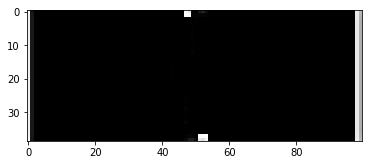

In [455]:
# function to normalize a matrix
def normalize(im, rmin = 0, rmax = 255):
    im_n = im.copy().astype(np.float)
    print("normalizing image with shape", im.shape)
    if (len(im.shape) == 2) or ((len(im.shape) > 2) and im.shape[2] == 1):
        im_float = im.astype(float)
        # gets the max and min values in the image
        vmax = im_float.max()
        vmin = im_float.min()
        # makes its values be between rmin and rmax
        if vmin != vmax:
            im_n = np.multiply((im_float - vmin), (rmax - rmin) / (vmax - vmin)) + rmin
        elif vmax != 0:
            im_n = im_float * (rmax - rmin) / vmax + rmin

    else:
        print("normalizing image with shape", im.shape)
#        if im.shape[2] > 1:
        for i in range(im.shape[2]):
            im_channel = im[:,:,i].astype(np.float)
            # gets the max and min values in the image
            vmax = np.max(im_channel)
            vmin = np.min(im_channel)
            # makes its values be between rmin and rmax
            if vmin != vmax:
                im_n[:,:,i] = np.multiply((im_channel - vmin), (rmax - rmin) / (vmax - vmin)) + rmin
            elif vmax != 0:
                im_n[:,:,i] = im_channel * (rmax - rmin) / vmax + rmin
#        else:
#            im_n = im.astype(np.float)
#            # gets the max and min values in the image
#            vmax = np.max(im_channel)
#            vmin = np.min(im_channel)
#            # makes its values be between rmin and rmax
#            if vmin != vmax:
#                im_n[:,:,i] = np.multiply((im_channel - vmin), (rmax - rmin) / (vmax - vmin)) + rmin
#            elif vmax != 0:
#                im_n[:,:,i] = im_channel * (rmax - rmin) / vmax + rmin

    if(rmin >= 0 and rmax <= 255):
        return im_n.astype(np.uint8)

    return im_n


plt.figure()
plt.imshow(normalize(simple_f) - normalize(simple_fft), cmap="gray")
plt.show()

In [7]:
simple_gray = rgb2gray(simple)

In [8]:
def rgb2xyz(im):
    mat = np.array([[0.49, 0.31, 0.20],
           [0.17697, 0.81240, 0.01063],
           [0.00, 0.01, 0.99]])
    fraction = (1.0 / 0.17697)
    xyzim = np.zeros(im.shape, dtype = np.uint32)
    if len(im.shape) == 3:
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
                xyzim[i][j] = fraction * (mat.dot(im[i][j].astype(np.uint32)))
    else:
        for i in range(im.shape[0]):
            xyzim[i] = fraction * (mat.dot(im[i].astype(np.uint32)))
    return xyzim

In [9]:
isso = np.array([[[255, 255, 0],
                  [255, 0, 3],
                  [3, 255, 255]],
                 [[255, 0, 120],
                  [120, 255, 4],
                  [120, 150, 60]],
                 [[150, 255, 3],
                  [60, 255, 120],
                  [30, 40, 60]]], dtype=np.uint32)
print(isso.shape)
print(rgb2xyz(isso))
print(normalize(isso))
isso2=np.array([[30, 40, 60]], dtype=np.uint32)
#print(isso2.shape)
isso2=rgb2xyz(isso2)
print(isso2)
normalize(isso2)

(3, 3, 3)
[[[1152 1425   14]
  [ 709  255   16]
  [ 743 1188 1440]]

 [[ 841  262  671]
  [ 783 1290   36]
  [ 662  812  344]]

 [[ 865 1320   31]
  [ 748 1237  685]
  [ 220  217  337]]]
[[[255 255   0]
  [255   0   3]
  [  0 255 255]]

 [[255   0 120]
  [118 255   4]
  [118 150  60]]

 [[148 255   3]
  [ 57 255 120]
  [ 27  40  60]]]
[[220 217 337]]


array([[  6,   0, 255]], dtype=uint8)

In [11]:
simple_lightless = removeLuminosityEffect(simple_gray)
#simple_lightless2 = removeLuminosityEffect2(simple_gray)

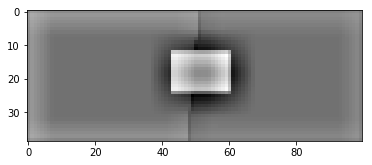

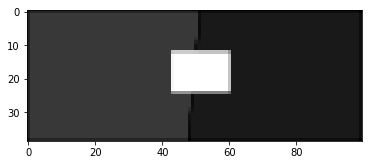

In [12]:
plt.imshow(simple_lightless, cmap='gray')
plt.show()
plt.imshow(simple_gray, cmap='gray')
plt.show()

In [193]:
simple_em = getLawsEnergyMaps(simple)
print("min", simple_em.min(), "max", simple_em.max())

hists, stride = lawsHist(simple_em)#, imprime=True)
print(stride)

min 6.603910417638078e-15 max 5901.38047142857
19305


(34,)


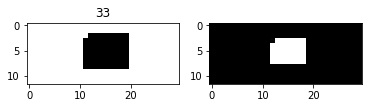

TypeError: __init__() should return None, not 'tuple'

In [586]:
matcher = matcher(simple, simple_mask[:,:,0], window_size=3, texType="lbpHist", lawsUsedMaps=None, normalizeMaps=True)

In [450]:
print(matcher._tex.shape)
print(matcher._tex[0].shape)
print(matcher._colorLevels)

(2, 12, 30)
(12, 30)


AttributeError: 'matcher' object has no attribute '_colorLevels'

pixelsListLen 34


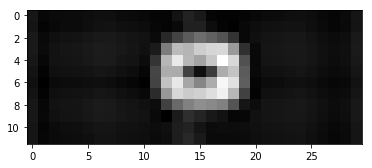

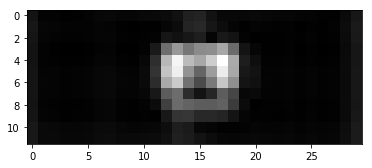

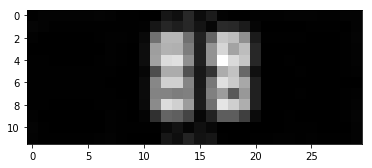

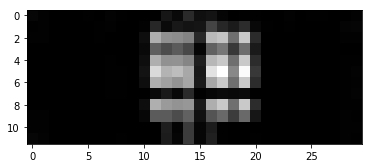

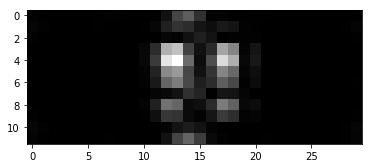

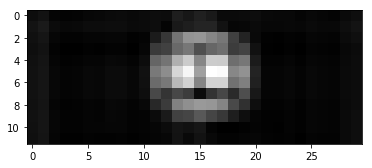

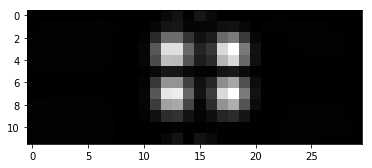

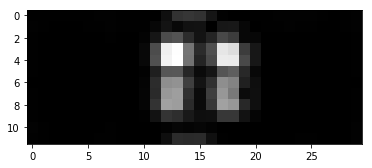

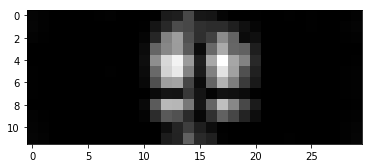

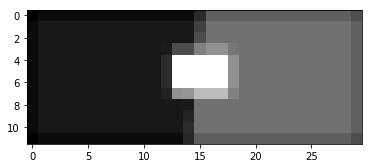

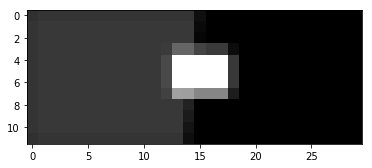

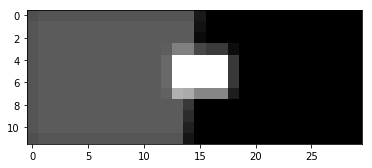

(12, 12, 30)
(12, 30)
primeiro pixel (3, 13)
0.2647058823529412
im min 0.0 max 255.0


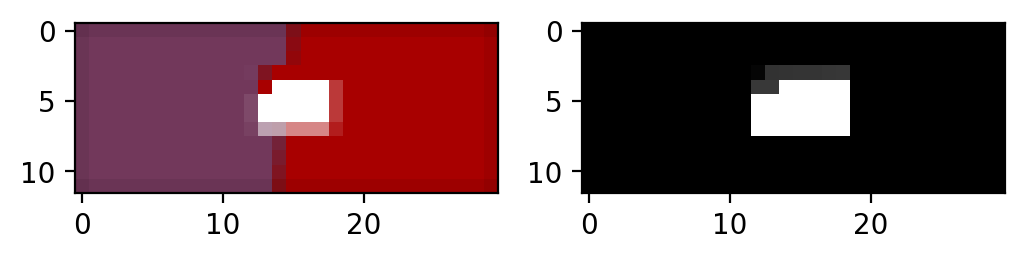

0.5
im min 0.0 max 255.0


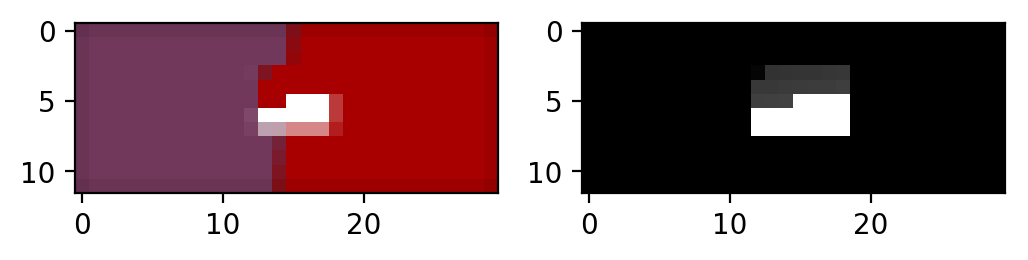

0.7647058823529412
im min 0.0 max 255.0


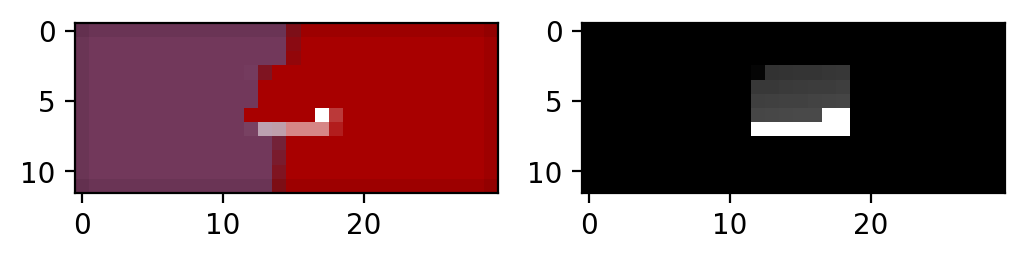

1.0
im min 0.0 max 178.0


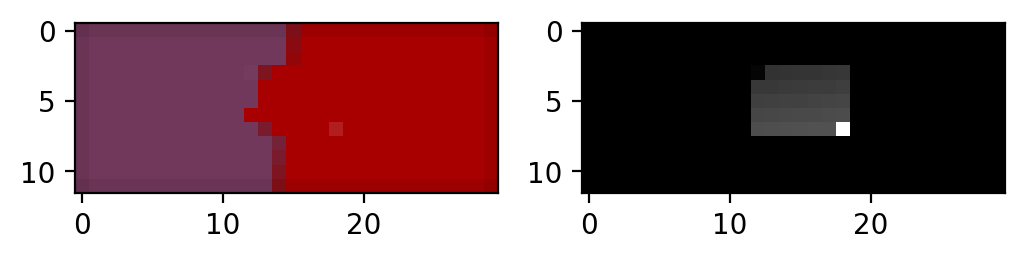

100.0
im min 0.0 max 168.0


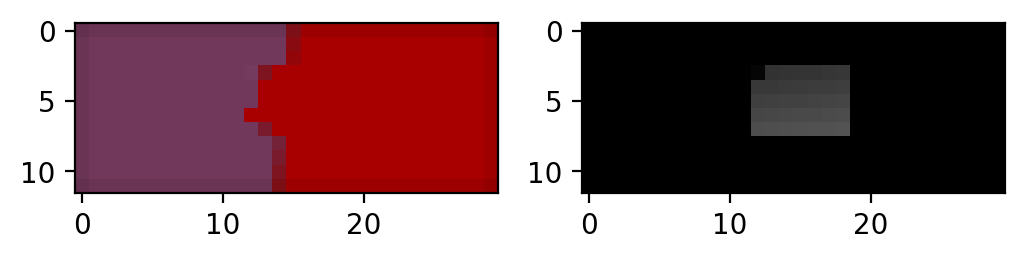

In [600]:
for (inpainted, maskOrder) in inpaint(simple, simple_mask, tolerance=0, generator=True, percent=0.25, normalizeMaps=False):
    print("im min", inpainted.min(), "max", inpainted.max())
    plt.figure(dpi=200)
    plt.subplot(121)
    plt.imshow(inpainted.astype(np.uint8))
    plt.subplot(122)
    plt.imshow(maskOrder, cmap="gray", vmin=0, vmax=255)
    plt.show()

pixelsListLen 34
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)


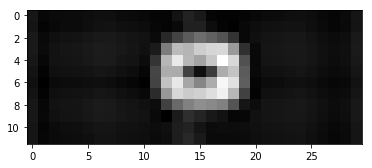

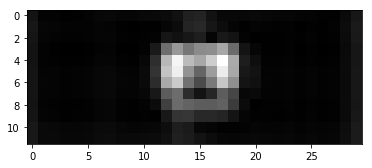

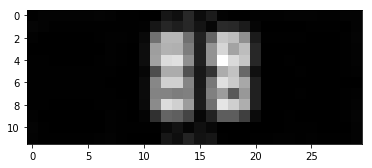

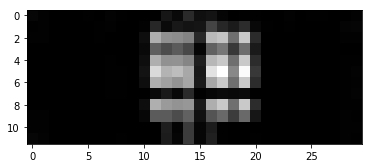

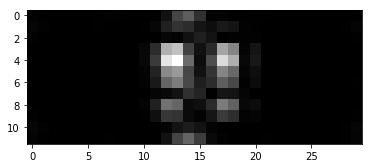

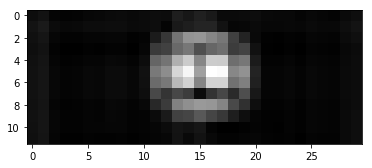

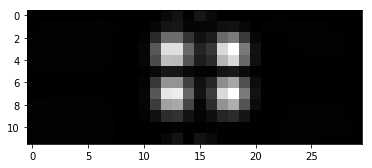

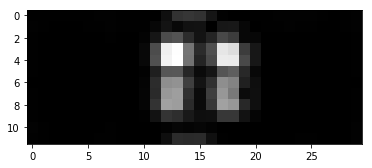

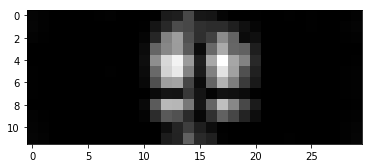

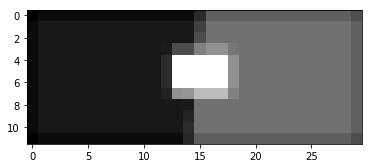

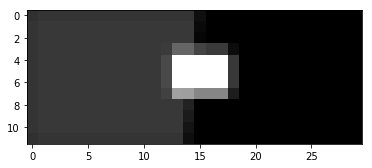

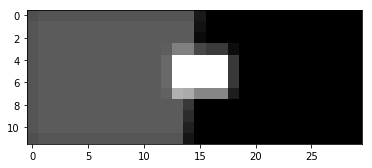

(12, 12, 30)
(12, 30)
primeiro pixel (3, 13)
0.2647058823529412
im min 0.0 max 168.0


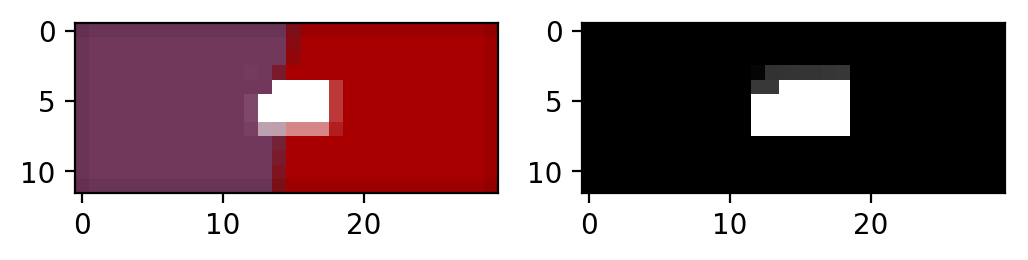

0.5
im min 0.0 max 168.0


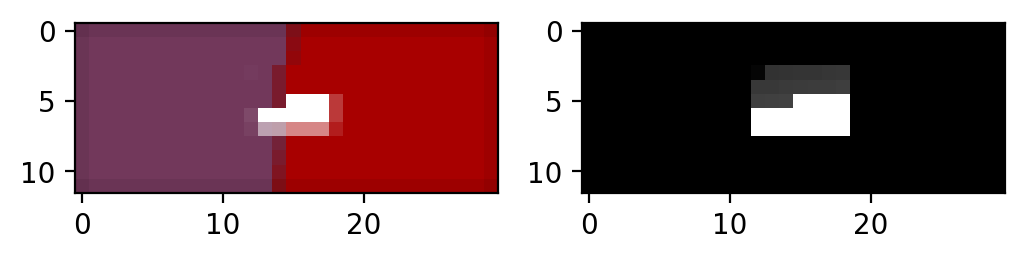

0.7647058823529412
im min 0.0 max 168.0


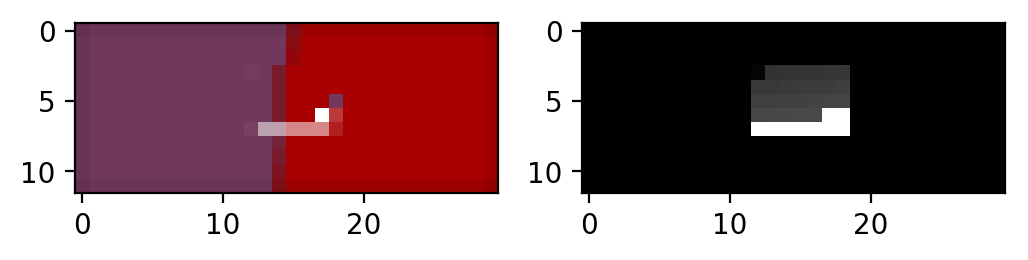

1.0
im min 0.0 max 168.0


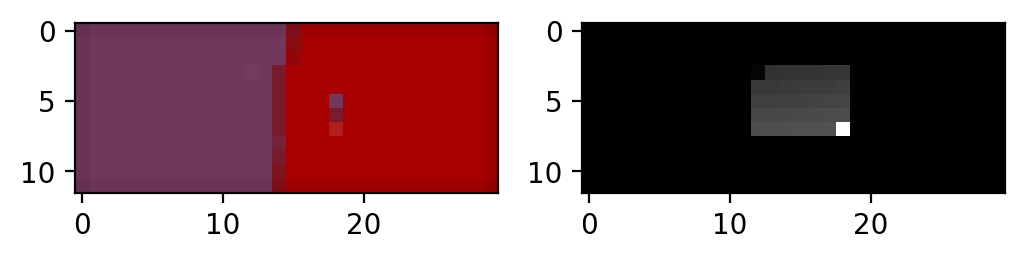

100.0
im min 0.0 max 168.0


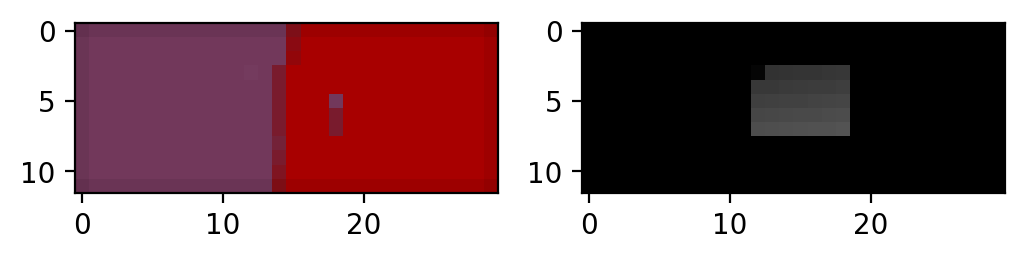

In [601]:
for (inpainted_n, maskOrder) in inpaint(simple, simple_mask, tolerance=0, generator=True, percent=0.25):
    print("im min", inpainted_n.min(), "max", inpainted.max())
    plt.figure(dpi=200)
    plt.subplot(121)
    plt.imshow(inpainted_n.astype(np.uint8))
    plt.subplot(122)
    plt.imshow(maskOrder, cmap="gray", vmin=0, vmax=255)
    plt.show()

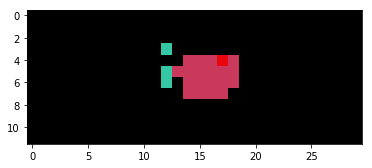

In [405]:
plt.imshow((inpainted - inpainted_n).astype(np.uint8))
plt.show()

pixelsListLen 234


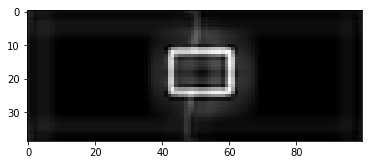

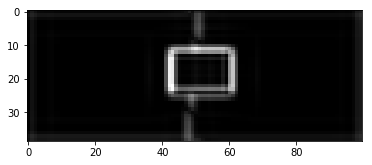

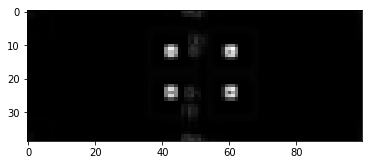

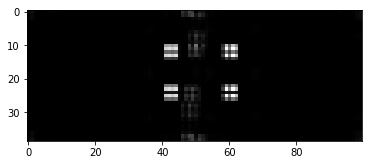

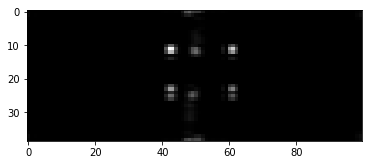

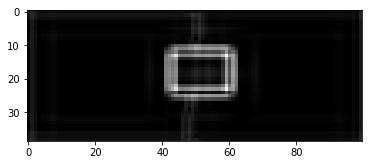

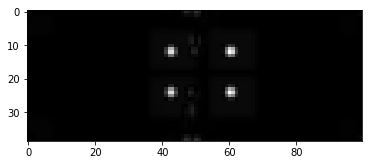

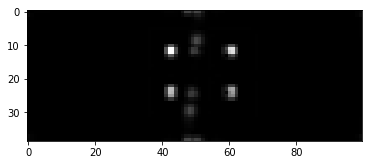

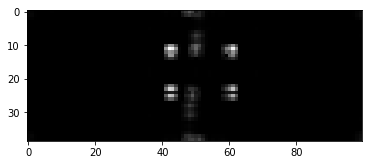

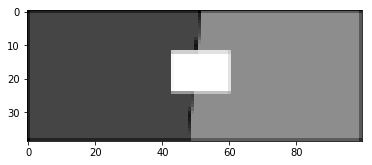

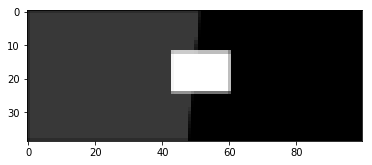

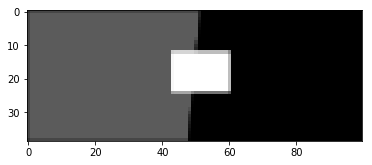

(12, 39, 100)
(39, 100)
primeiro pixel (12, 43)
0.25213675213675246
im min 0.0 max 168.0


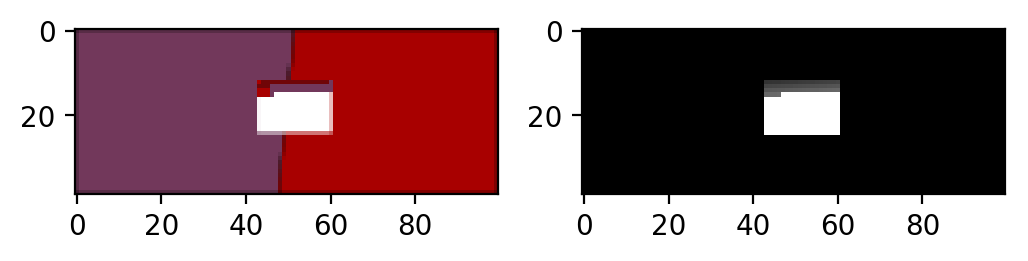

0.5042735042735037
im min 0.0 max 168.0


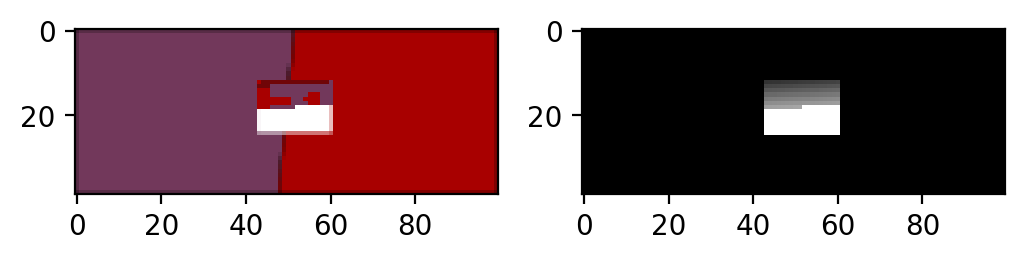

0.7521367521367507
im min 0.0 max 168.0


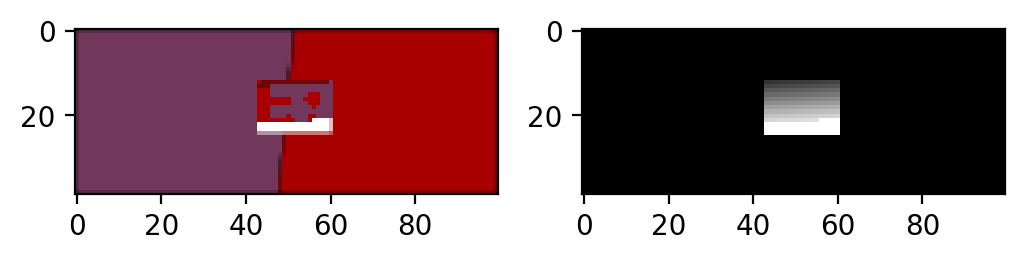

100.0
im min 0.0 max 168.0


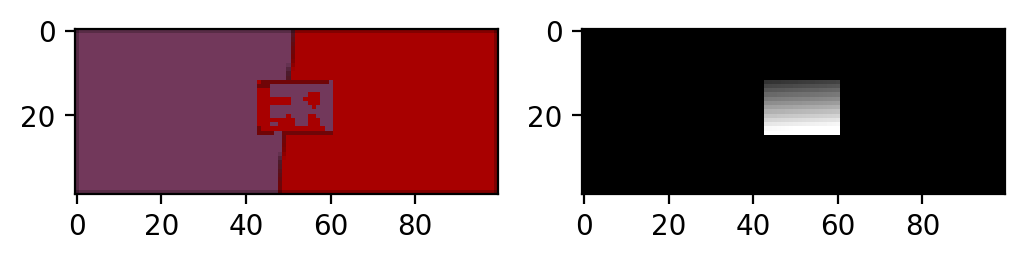

In [602]:
for (inpainted_mini, maskOrder) in inpaint(simple_mini, simple_mask_mini, tolerance=0, generator=True, percent=0.25, normalizeMaps=False):
    print("im min", inpainted_mini.min(), "max", inpainted.max())
    plt.figure(dpi=200)
    plt.subplot(121)
    plt.imshow(inpainted_mini.astype(np.uint8))
    plt.subplot(122)
    plt.imshow(maskOrder, cmap="gray", vmin=0, vmax=255)
    plt.show()

pixelsListLen 234
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)


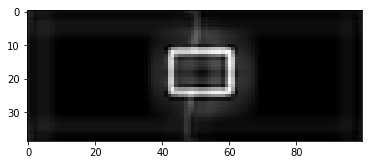

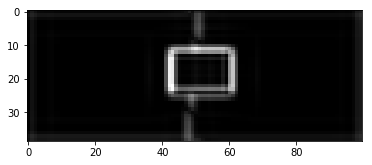

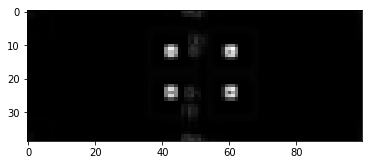

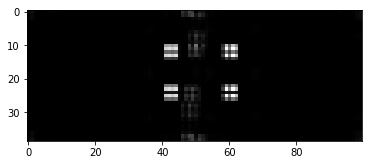

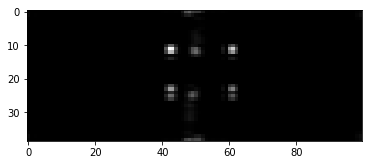

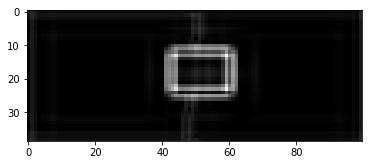

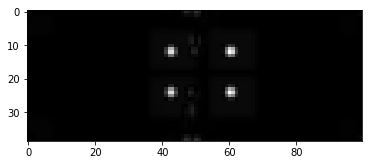

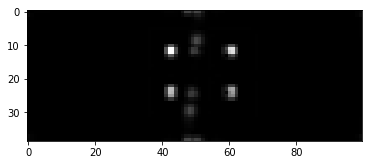

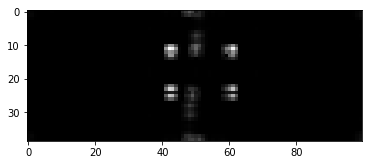

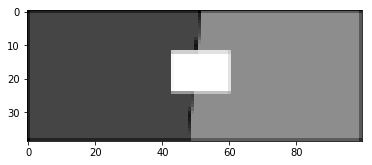

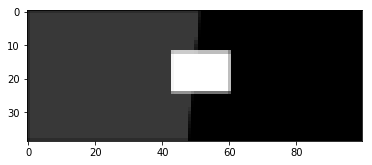

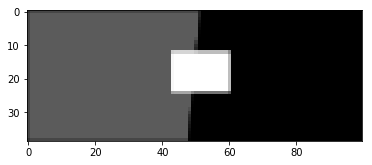

(12, 39, 100)
(39, 100)
primeiro pixel (12, 43)
0.25213675213675246
im min 0.0 max 168.0


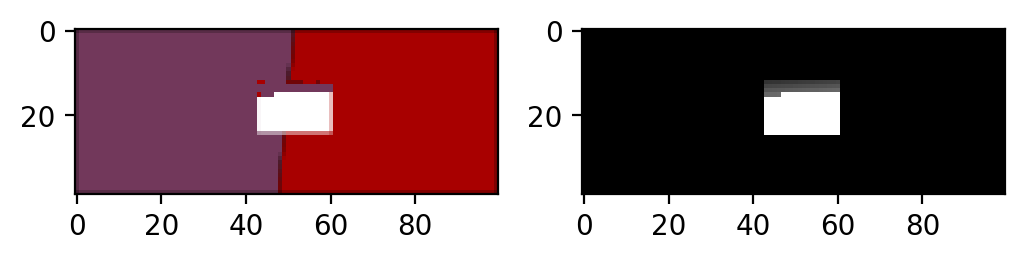

0.5042735042735037
im min 0.0 max 168.0


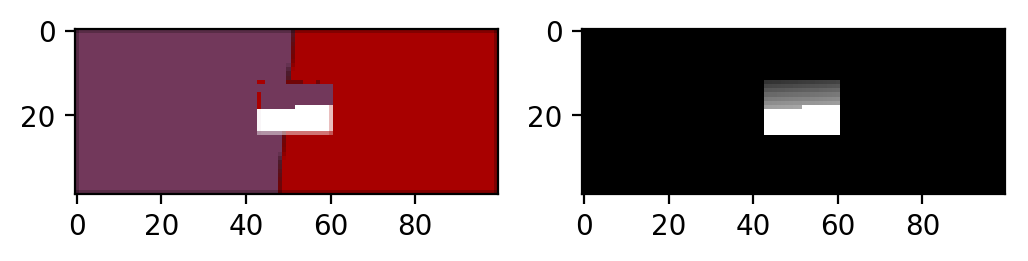

0.7521367521367507
im min 0.0 max 168.0


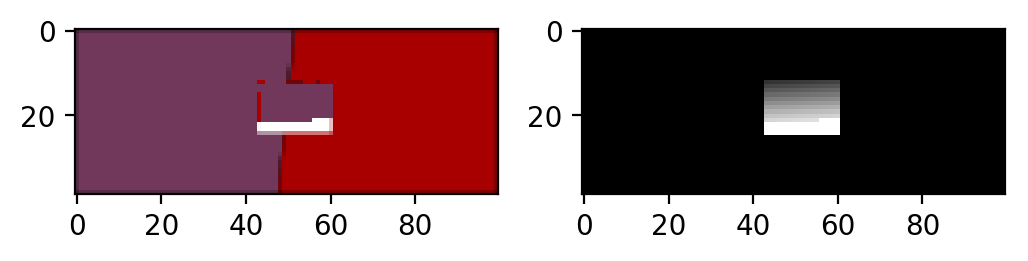

100.0
im min 0.0 max 168.0


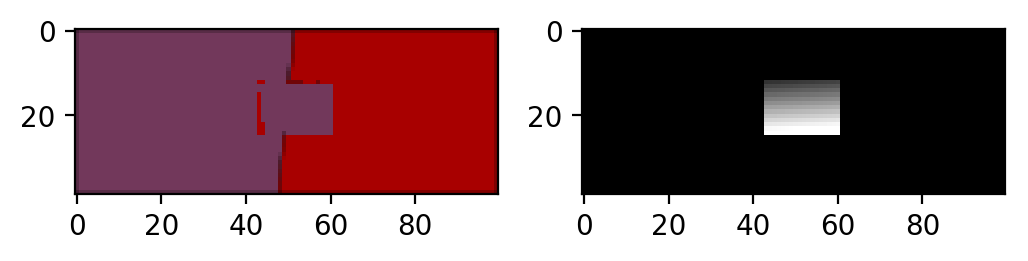

In [603]:
simple_mini = imgio.imread("./images/simple-damaged_mini.png").astype(np.uint8)
simple_mask_mini = imgio.imread("./images/simple-mask_mini.png").astype(np.uint8)

for (inpainted_mini_n, maskOrder) in inpaint(simple_mini, simple_mask_mini, tolerance=0, generator=True, percent=0.25):
    print("im min", inpainted_mini_n.min(), "max", inpainted.max())
    plt.figure(dpi=200)
    plt.subplot(121)
    plt.imshow(inpainted_mini_n.astype(np.uint8))
    plt.subplot(122)
    plt.imshow(maskOrder, cmap="gray", vmin=0, vmax=255)
    plt.show()

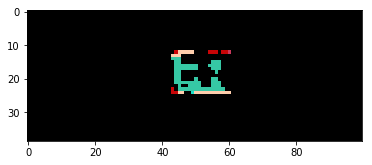

In [604]:
plt.imshow((inpainted_mini - inpainted_mini_n).astype(np.uint8))
plt.show()

pixelsListLen 34
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)


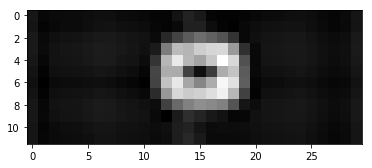

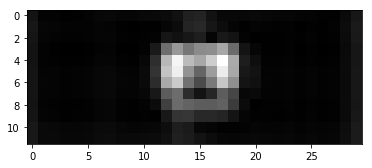

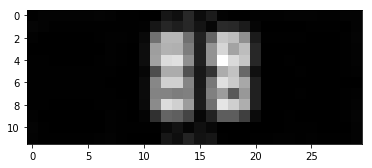

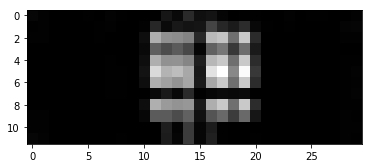

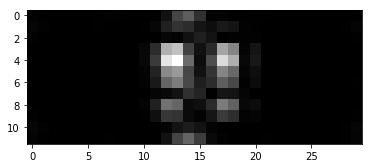

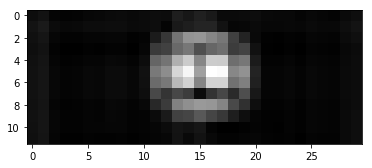

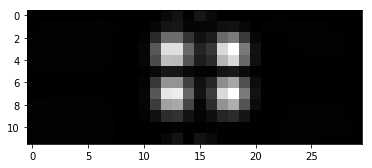

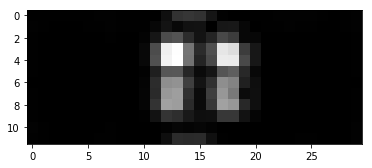

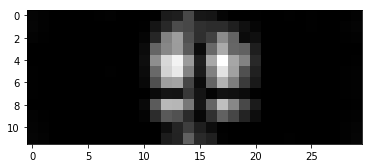

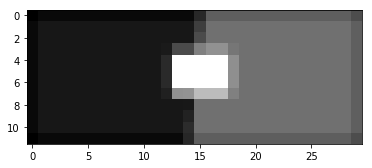

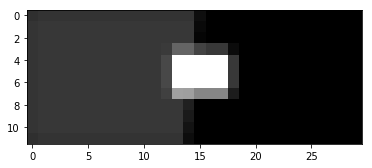

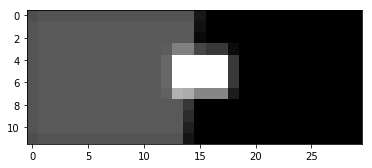

(12, 12, 30)
(12, 30)
primeiro pixel (3, 13)
0.2647058823529412
im min 0.0 max 168.0


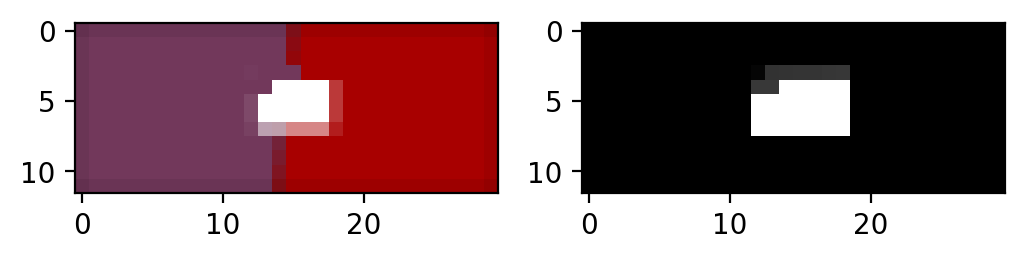

0.5
im min 0.0 max 168.0


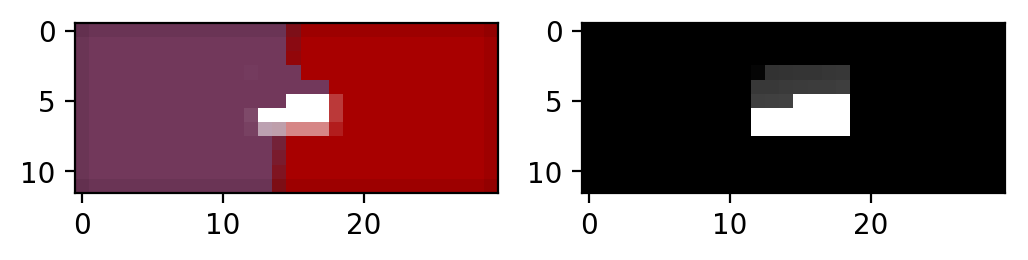

0.7647058823529412
im min 0.0 max 168.0


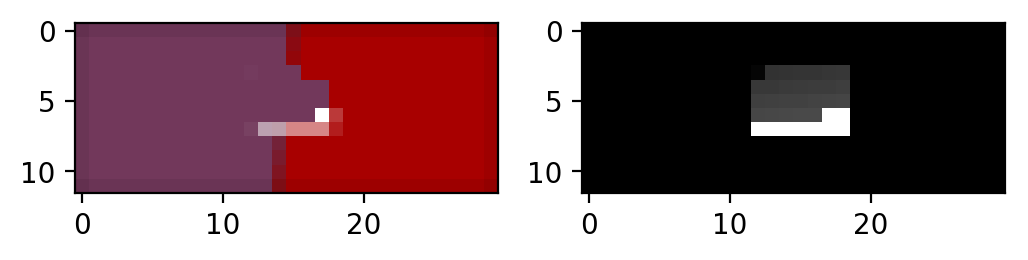

1.0
im min 0.0 max 168.0


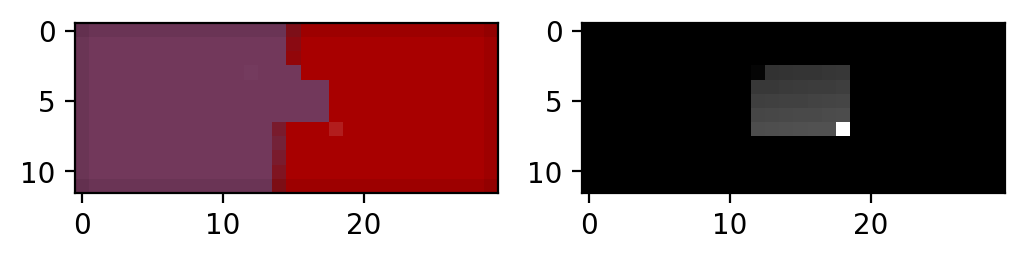

100.0
im min 0.0 max 168.0


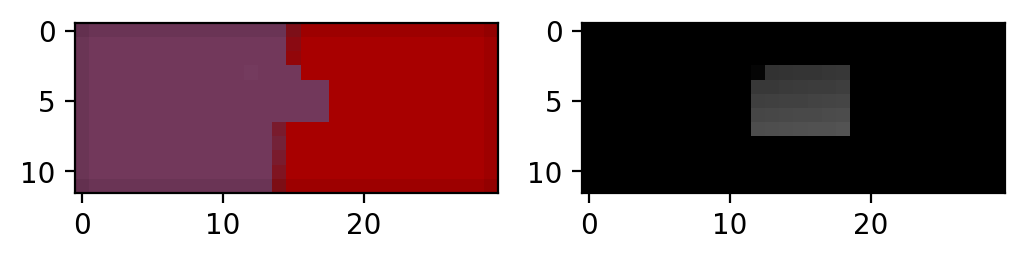

In [605]:
for (inpainted_h, maskOrder) in inpaint(simple, simple_mask, tex_match="lawsHist", tolerance=0, generator=True, percent=0.25):
    print("im min", inpainted_h.min(), "max", inpainted.max())
    plt.figure(dpi=200)
    plt.subplot(121)
    plt.imshow(inpainted_h.astype(np.uint8))
    plt.subplot(122)
    plt.imshow(maskOrder, cmap="gray", vmin=0, vmax=255)
    plt.show()

pixelsListLen 234
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)
normalizing image with shape (39, 100)


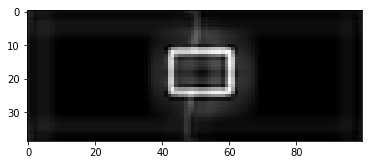

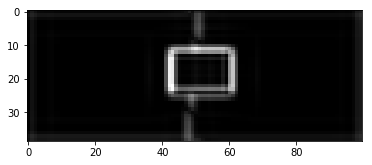

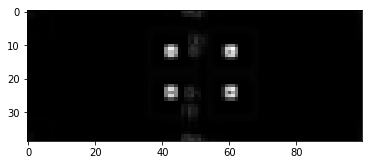

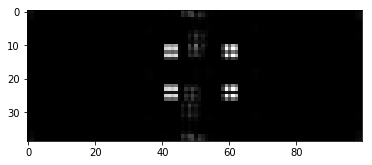

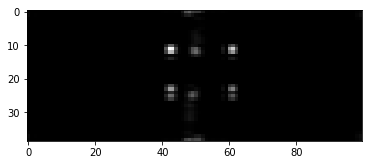

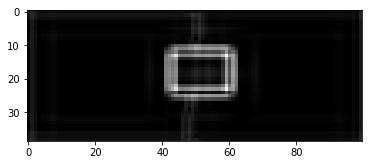

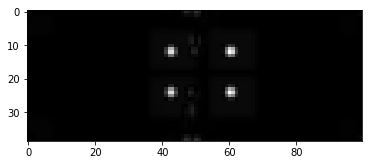

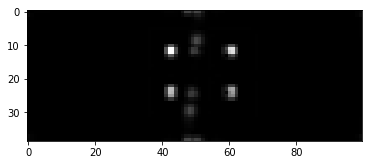

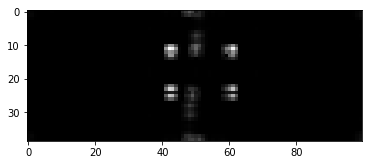

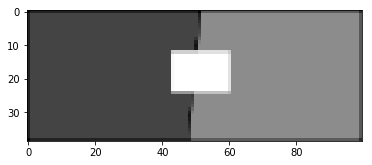

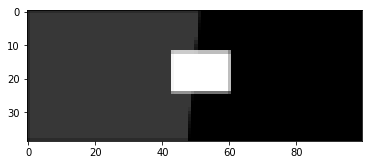

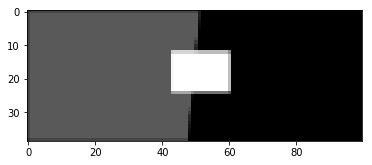

(12, 39, 100)
(39, 100)
primeiro pixel (12, 43)
0.25213675213675246
im min 0.0 max 168.0


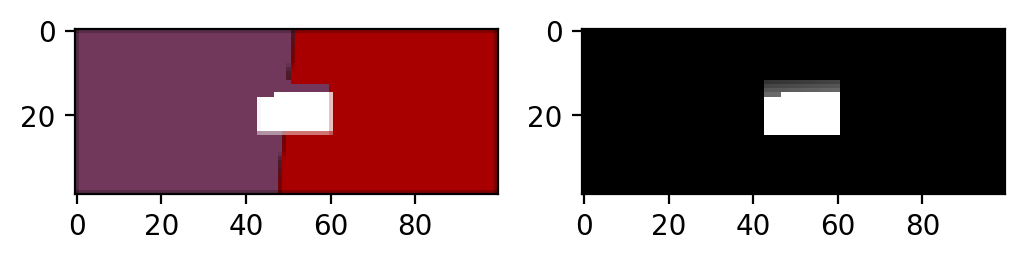

0.5042735042735037
im min 0.0 max 168.0


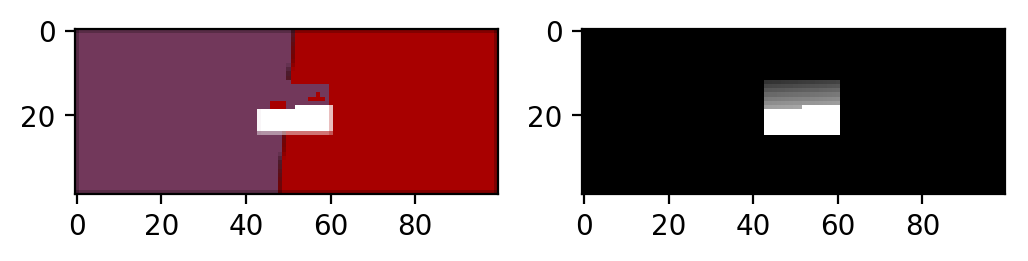

0.7521367521367507
im min 0.0 max 168.0


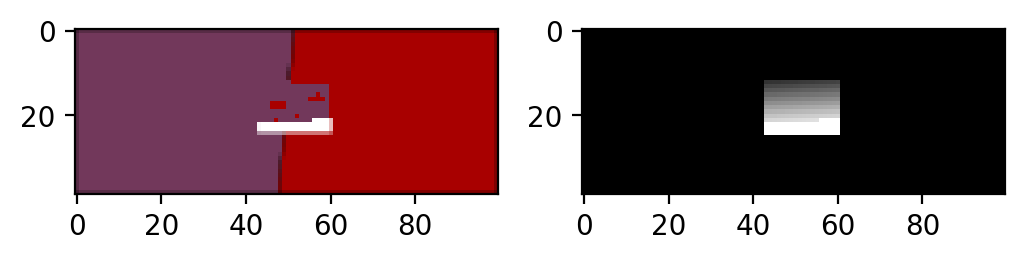

100.0
im min 0.0 max 168.0


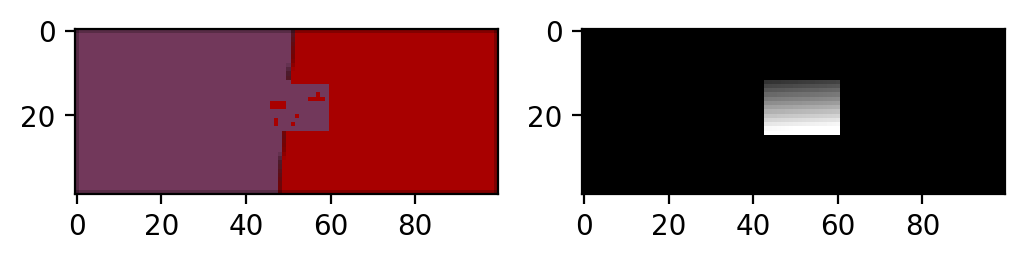

In [606]:
for (inpainted_h_mini, maskOrder) in inpaint(simple_mini, simple_mask_mini, tex_match="lawsHist", tolerance=0, generator=True, percent=0.25):
    print("im min", inpainted_h_mini.min(), "max", inpainted.max())
    plt.figure(dpi=200)
    plt.subplot(121)
    plt.imshow(inpainted_h_mini.astype(np.uint8))
    plt.subplot(122)
    plt.imshow(maskOrder, cmap="gray", vmin=0, vmax=255)
    plt.show()

pixelsListLen 34


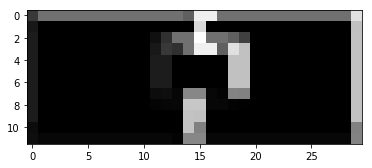

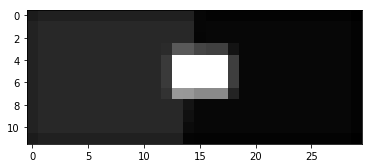

(2, 12, 30)
(12, 30)
primeiro pixel (3, 13)
0.2647058823529412
im min 0.0 max 255.0


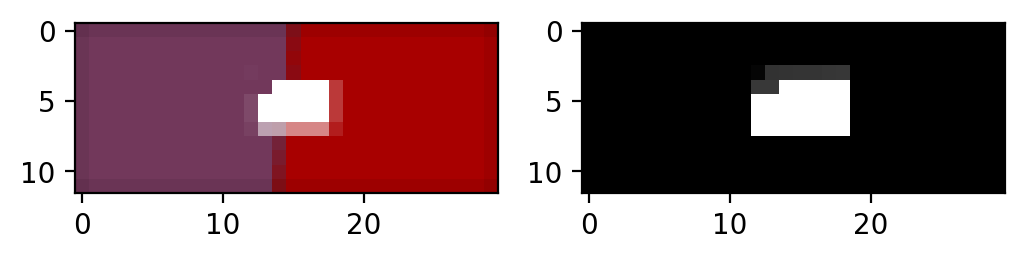

0.5
im min 0.0 max 255.0


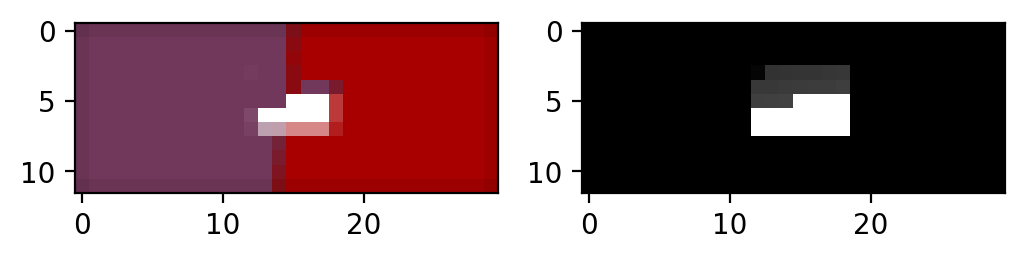

0.7647058823529412
im min 0.0 max 255.0


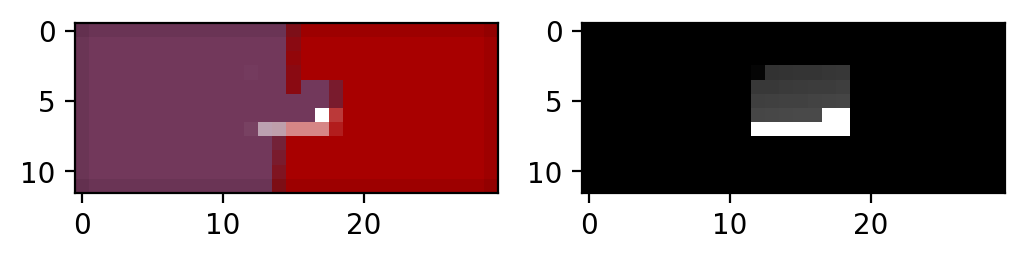

1.0
im min 0.0 max 178.0


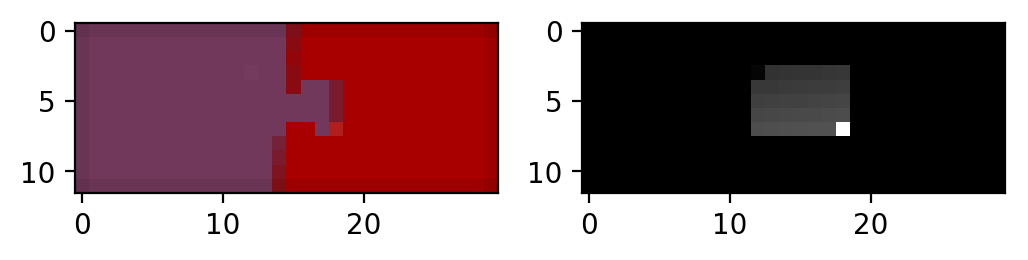

100.0
im min 0.0 max 168.0


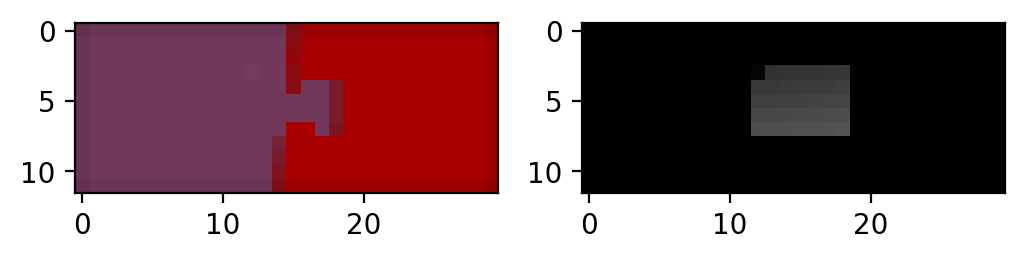

In [607]:
for (inpainted_lbp, maskOrder) in inpaint(simple, simple_mask, tex_match="lbp", tolerance=0, generator=True, percent=0.25):
    print("im min", inpainted_lbp.min(), "max", inpainted_lbp.max())
    plt.figure(dpi=200)
    plt.subplot(121)
    plt.imshow(inpainted_lbp.astype(np.uint8))
    plt.subplot(122)
    plt.imshow(maskOrder, cmap="gray", vmin=0, vmax=255)
    plt.show()

pixelsListLen 234


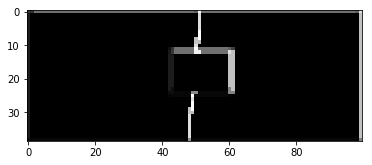

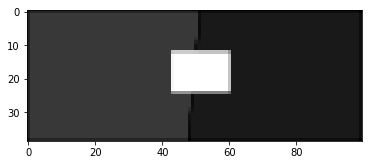

(2, 39, 100)
(39, 100)
primeiro pixel (12, 43)
0.25213675213675246
im min 0.0 max 255.0


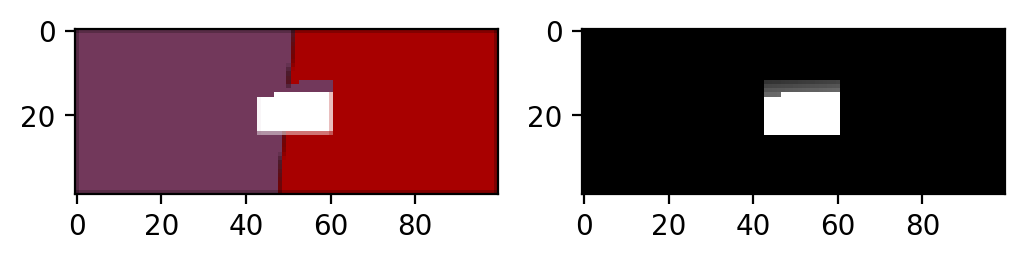

0.5042735042735037
im min 0.0 max 255.0


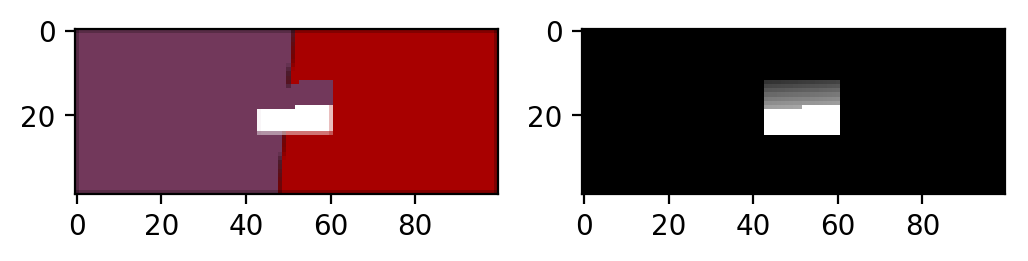

0.7521367521367507
im min 0.0 max 255.0


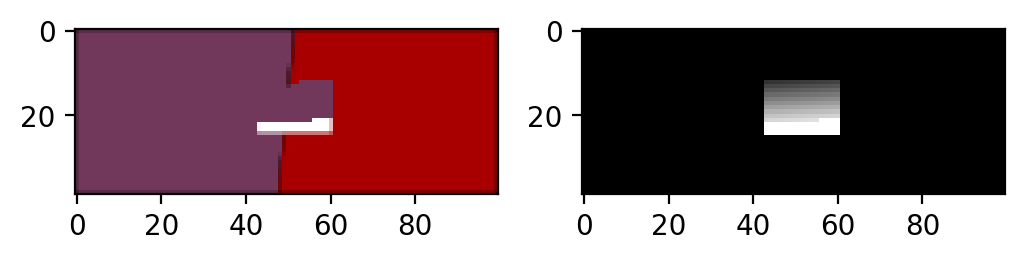

100.0
im min 0.0 max 168.0


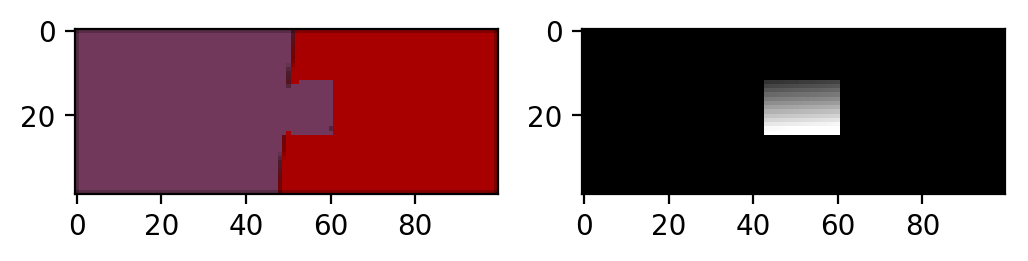

In [608]:
for (inpainted_lbp_mini, maskOrder) in inpaint(simple_mini, simple_mask_mini, tex_match="lbp", tolerance=0, generator=True, percent=0.25):
    print("im min", inpainted_lbp_mini.min(), "max", inpainted_lbp_mini.max())
    plt.figure(dpi=200)
    plt.subplot(121)
    plt.imshow(inpainted_lbp_mini.astype(np.uint8))
    plt.subplot(122)
    plt.imshow(maskOrder, cmap="gray", vmin=0, vmax=255)
    plt.show()

pixelsListLen 34
normalizing image with shape (12, 30)
normalizing image with shape (12, 30)


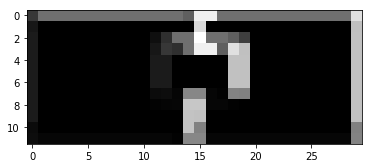

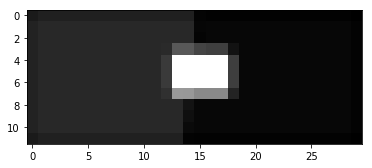

(2, 12, 30)
(12, 30)
primeiro pixel (3, 13)
0.2647058823529412
im min 0.0 max 168.0


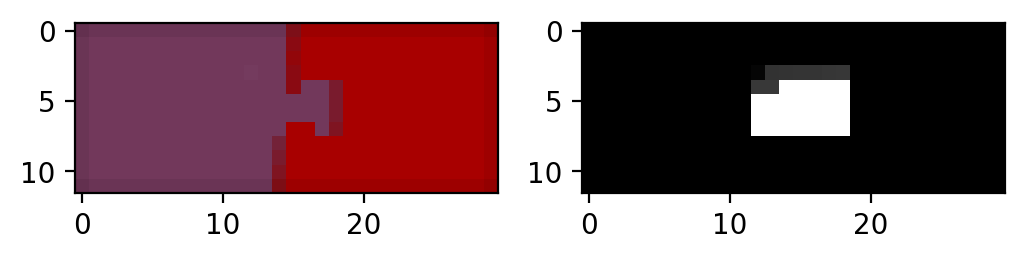

0.5
im min 0.0 max 168.0


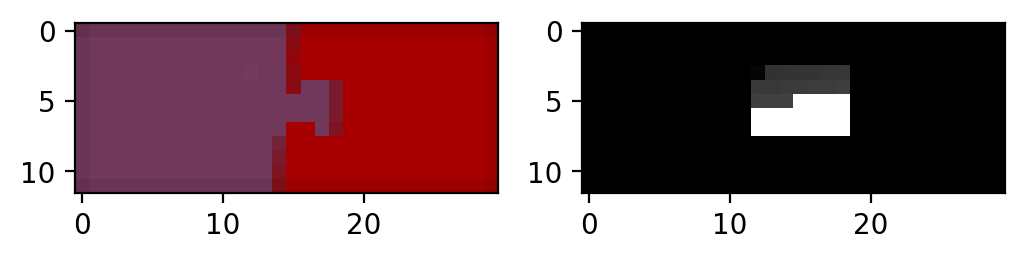

0.7647058823529412
im min 0.0 max 168.0


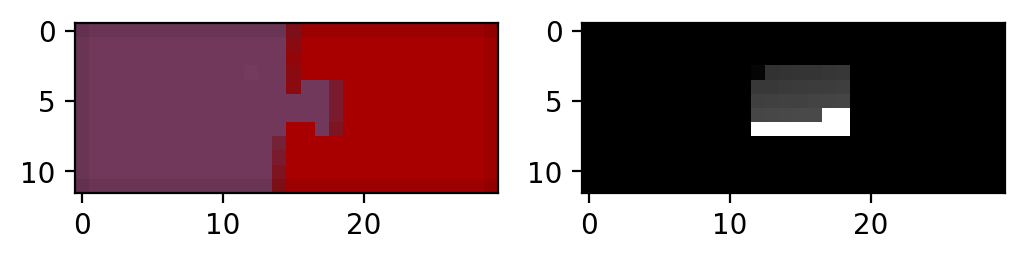

1.0
im min 0.0 max 168.0


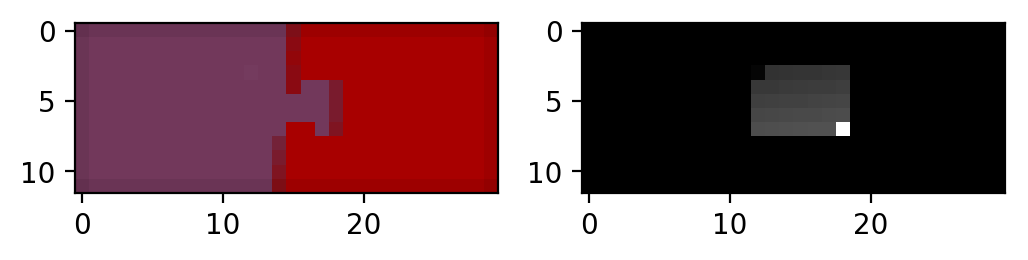

100.0
im min 0.0 max 168.0


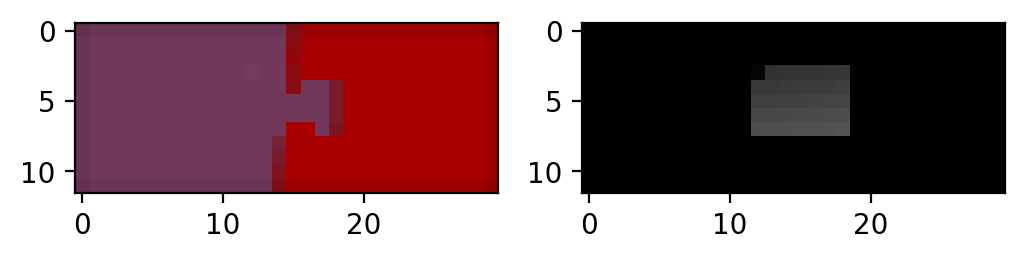

In [613]:
for (inpainted_lbp_h, maskOrder) in inpaint(simple, simple_mask, tex_match="lbpHist", tolerance=0, generator=True, percent=0.25):
    print("im min", inpainted_lbp.min(), "max", inpainted_lbp.max())
    plt.figure(dpi=200)
    plt.subplot(121)
    plt.imshow(inpainted_lbp.astype(np.uint8))
    plt.subplot(122)
    plt.imshow(maskOrder, cmap="gray", vmin=0, vmax=255)
    plt.show()

pixelsListLen 234


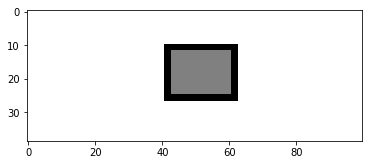

normalizing image with shape (39, 100)
normalizing image with shape (39, 100)


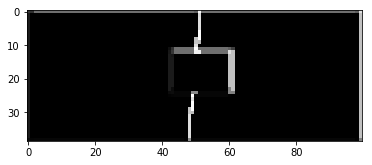

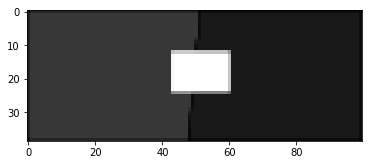

(2, 39, 100)
(39, 100)
primeiro pixel (12, 43)
0.25213675213675246
im min 0.0 max 255.0


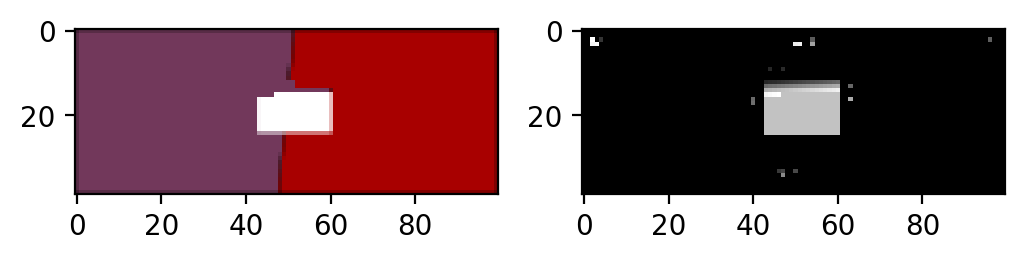

0.5042735042735037
im min 0.0 max 255.0


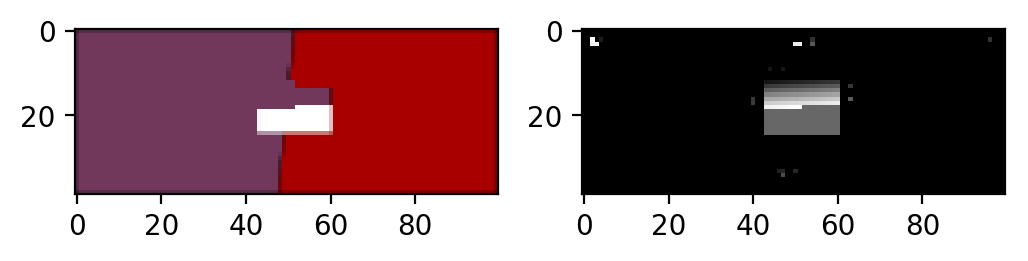

0.7521367521367507
im min 0.0 max 255.0


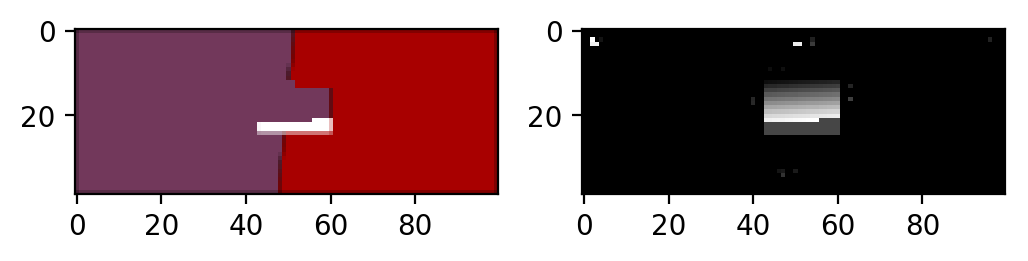

100.0
im min 0.0 max 168.0


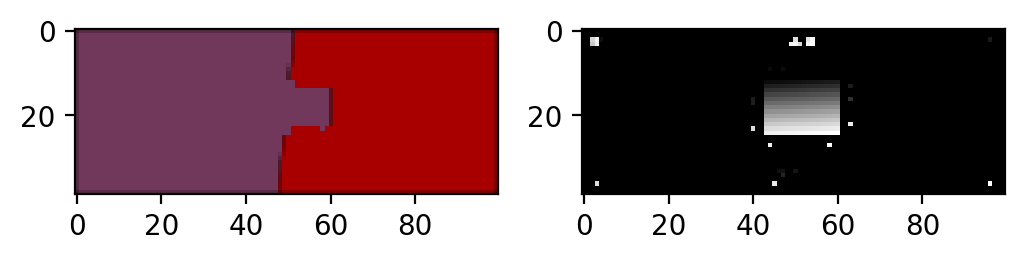

In [635]:
for (inpainted_lbp_mini_h, maskOrder) in inpaint(simple_mini, simple_mask_mini, tex_match="lbpHist", window_match_size=5, tolerance=0, generator=True, percent=0.25):
    print("im min", inpainted_lbp_mini_h.min(), "max", inpainted_lbp_mini_h.max())
    plt.figure(dpi=200)
    plt.subplot(121)
    plt.imshow(inpainted_lbp_mini_h.astype(np.uint8))
    plt.subplot(122)
    plt.imshow(maskOrder, cmap="gray", vmin=maskOrder.min(), vmax=maskOrder.max())
    plt.show()

pixelsListLen 69


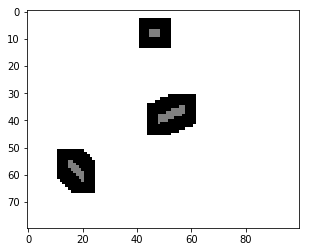

normalizing image with shape (80, 100)
normalizing image with shape (80, 100)


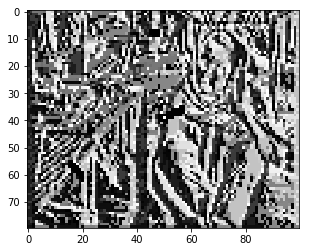

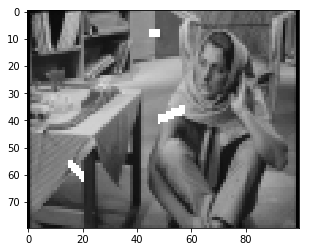

(2, 80, 100)
(80, 100)
primeiro pixel (7, 45)
0.26086956521739135
im min 6.0 max 255.0


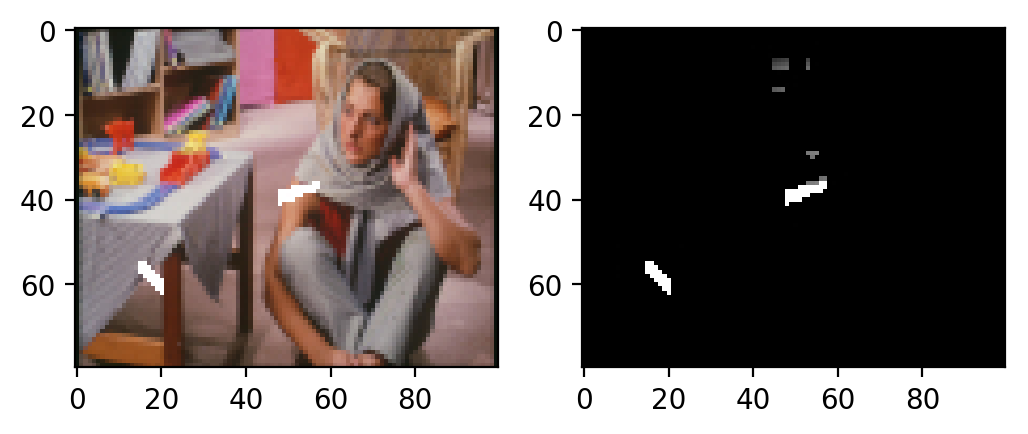

0.5072463768115943
im min 6.0 max 255.0


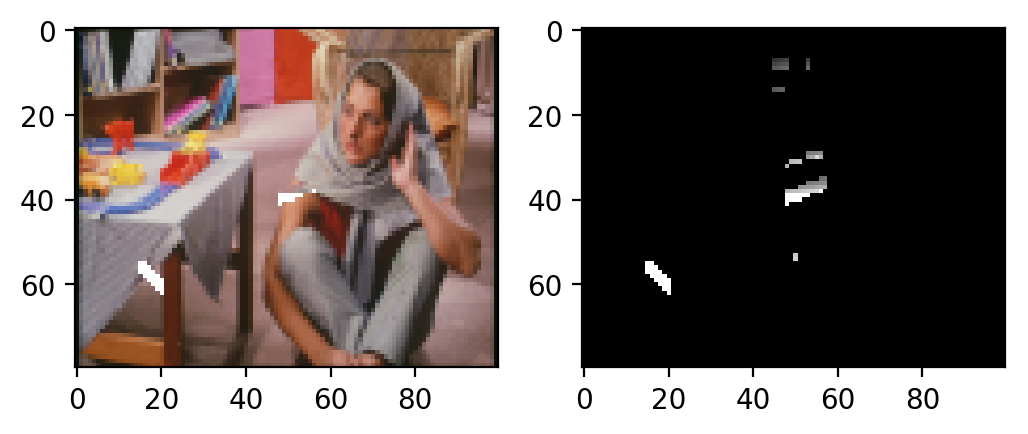

0.7536231884057965
im min 6.0 max 255.0


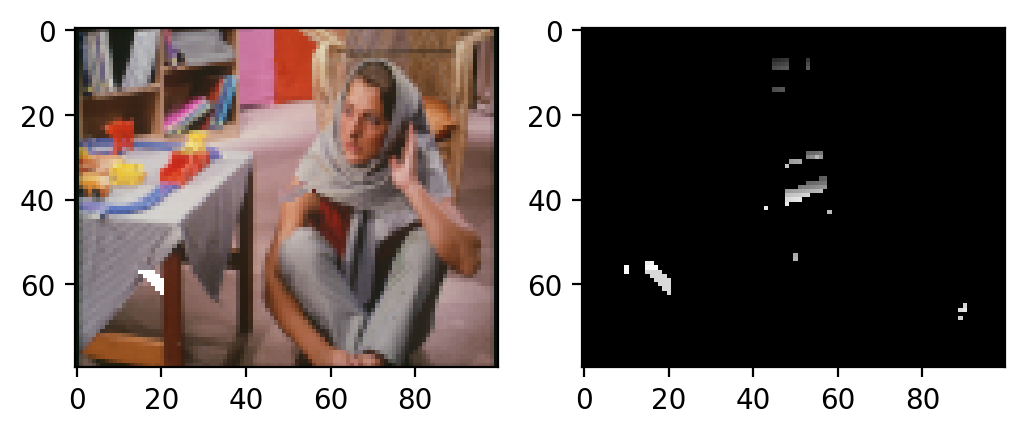

100.0
im min 6.0 max 245.0


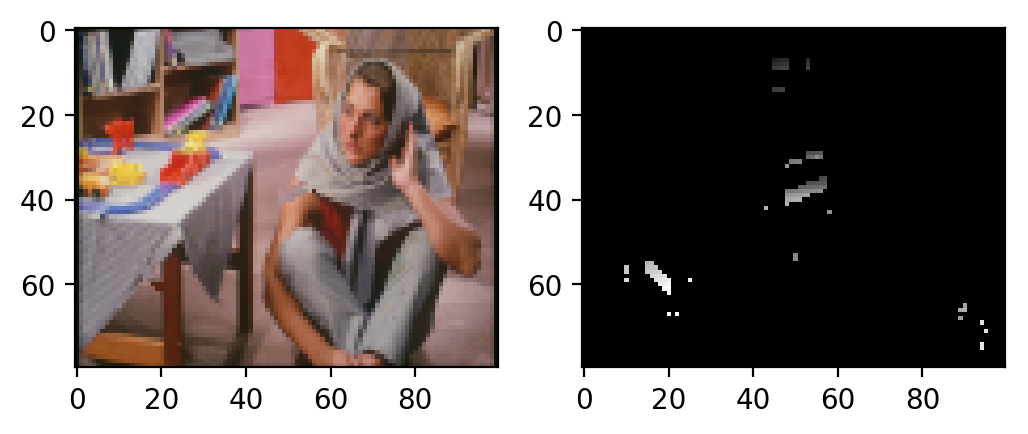

In [640]:
barbara_mini = imgio.imread("images/barbara-damaged_mini.jpg").astype(np.uint8)
barbara_mask_mini = imgio.imread("images/barbara-mask_mini.jpg").astype(np.uint8)

for (barbara_lbp_mini_h, maskOrder) in inpaint(barbara_mini, barbara_mask_mini, window_match_size=9, window_tex_size=3, tex_match="lbpHist", tolerance=0, generator=True, percent=0.25):
    print("im min", barbara_lbp_mini_h.min(), "max", barbara_lbp_mini_h.max())
    plt.figure(dpi=200)
    plt.subplot(121)
    plt.imshow(barbara_lbp_mini_h.astype(np.uint8))
    plt.subplot(122)
    plt.imshow(maskOrder, vmin=maskOrder.min(), vmax=maskOrder.max(), cmap='gray')
    plt.show()

pixelsListLen 69


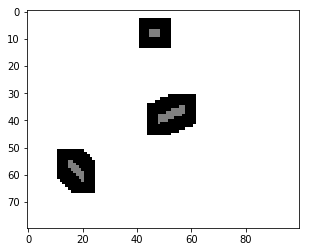

normalizing image with shape (80, 100)
normalizing image with shape (80, 100)


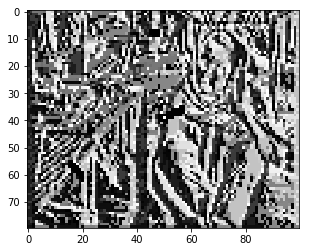

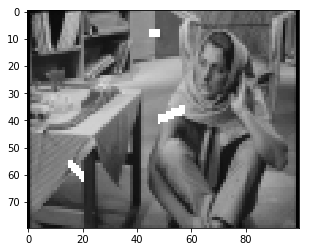

(2, 80, 100)
(80, 100)
primeiro pixel (7, 45)
0.26086956521739135
im min 6.0 max 255.0


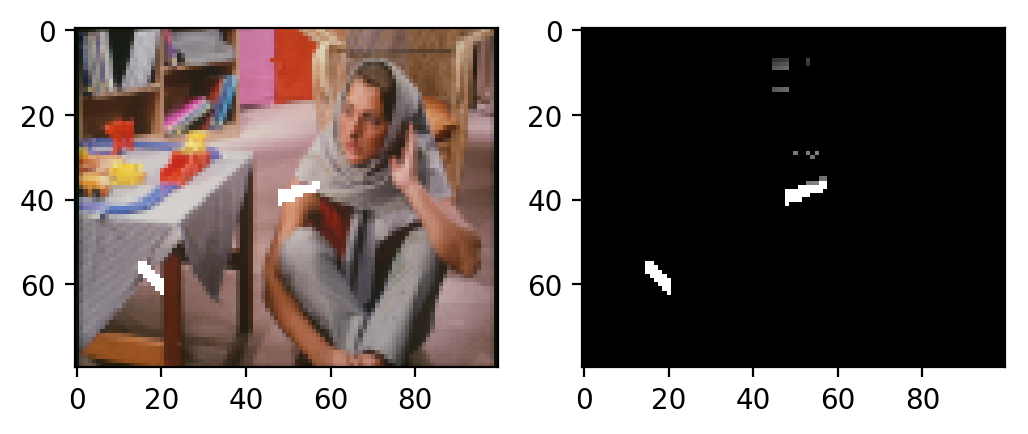

0.5072463768115943
im min 6.0 max 255.0


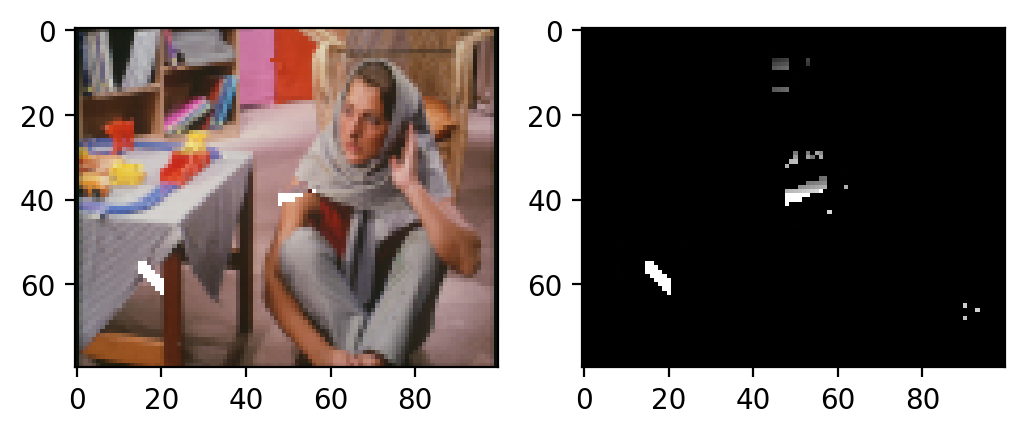

0.7536231884057965
im min 6.0 max 255.0


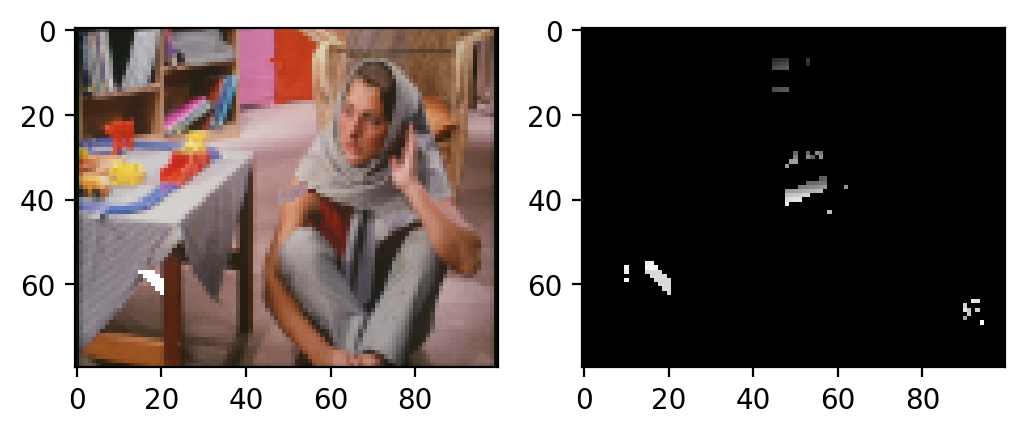

100.0
im min 6.0 max 245.0


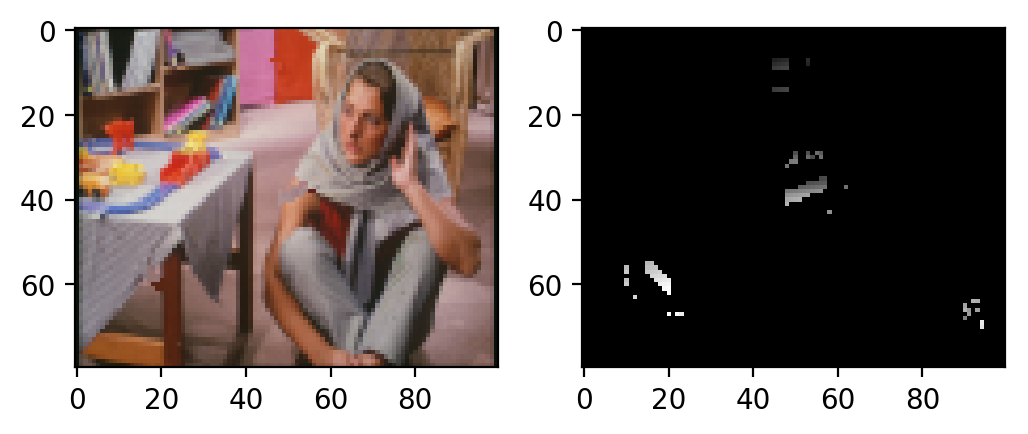

In [641]:
for (barbara_lbp_mini_h, maskOrder) in inpaint(barbara_mini, barbara_mask_mini, recompute=True, window_match_size=9, window_tex_size=3, tex_match="lbpHist", tolerance=0, generator=True, percent=0.25):
    print("im min", barbara_lbp_mini_h.min(), "max", barbara_lbp_mini_h.max())
    plt.figure(dpi=200)
    plt.subplot(121)
    plt.imshow(barbara_lbp_mini_h.astype(np.uint8))
    plt.subplot(122)
    plt.imshow(maskOrder, vmin=maskOrder.min(), vmax=maskOrder.max(), cmap='gray')
    plt.show()

In [ ]:
plt.figure(dpi=200)
plt.subplot(121)
plt.imshow(normalize(inpainted))
plt.subplot(122)
plt.imshow(maskOrder, cmap="gray", vmin=0, vmax=255)
plt.show()